# Цель исследования

Чтобы оптимизировать производственные расходы, металлургический комбинат «Стальная птица» решил уменьшить потребление электроэнергии на этапе обработки стали. Для этого комбинату нужно контролировать температуру сплава. Цель проекта — построить модель, которая будет предсказывать температуру сплава. 
Заказчик хочет использовать разработанную модель для имитации технологического процесса.

План работы:

- предобработка данных
- исследовательский анализ
- корреляционный анализ
- подготовка данных
- обучение моделей
- общий вывод

In [1]:
%pip install phik -q

Note: you may need to restart the kernel to use updated packages.


In [2]:
%pip install shap -q

Note: you may need to restart the kernel to use updated packages.


In [3]:
!pip install -U scikit-learn -q

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as st
import numpy as np
import phik
import shap

from sklearn.model_selection import (
    train_test_split,
    GridSearchCV,
    RandomizedSearchCV
)

from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

from sklearn.impute import SimpleImputer
from lightgbm import LGBMRegressor

from sklearn.preprocessing import (
    OneHotEncoder,
    StandardScaler,
    OrdinalEncoder,
    MinMaxScaler,
    RobustScaler
)
from sklearn.metrics import (
    mean_squared_error,
    r2_score,
    mean_absolute_error,
    confusion_matrix,
    precision_score,
    recall_score,
    accuracy_score,
    roc_auc_score,
    make_scorer
)

import catboost as cb


from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

RANDOM_STATE = 80424
TEST_SIZE = 0.25

## Загрузка данных

In [5]:
def load_csv(file_name):
    try:
        return pd.read_csv(f'/datasets/{file_name}', sep=',')
    except:
        return pd.read_csv(
            f'https://code.s3.yandex.net/datasets/{file_name}', sep=',')

In [6]:
def show_info(df):
    return display(df.head()), display(df.info())

In [7]:
data_arc = load_csv('data_arc_new.csv')

In [8]:
show_info(data_arc)

key Начало нагрева дугой  Конец нагрева дугой  Активная мощность  \
0    1  2019-05-03 11:02:14  2019-05-03 11:06:02           0.305130   
1    1  2019-05-03 11:07:28  2019-05-03 11:10:33           0.765658   
2    1  2019-05-03 11:11:44  2019-05-03 11:14:36           0.580313   
3    1  2019-05-03 11:18:14  2019-05-03 11:24:19           0.518496   
4    1  2019-05-03 11:26:09  2019-05-03 11:28:37           0.867133   

   Реактивная мощность  
0             0.211253  
1             0.477438  
2             0.430460  
3             0.379979  
4             0.643691

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key                   14876 non-null  int64  
 1   Начало нагрева дугой  14876 non-null  object 
 2   Конец нагрева дугой   14876 non-null  object 
 3   Активная мощность     14876 non-null  float64
 4   Реактивная мощность   14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB


None

(None, None)

В таблице присутствует 14876 записей, пропуски в значениях отсутствуют. Для возможности проведения вычеслений нужно будет изменить тип данных с датой и временем. Столбцы нужно будет переименовать для удобства в работе.

In [9]:
data_bulk = load_csv('data_bulk_new.csv')

In [10]:
show_info(data_bulk)

key  Bulk 1  Bulk 2  Bulk 3  Bulk 4  Bulk 5  Bulk 6  Bulk 7  Bulk 8  \
0    1     NaN     NaN     NaN    43.0     NaN     NaN     NaN     NaN   
1    2     NaN     NaN     NaN    73.0     NaN     NaN     NaN     NaN   
2    3     NaN     NaN     NaN    34.0     NaN     NaN     NaN     NaN   
3    4     NaN     NaN     NaN    81.0     NaN     NaN     NaN     NaN   
4    5     NaN     NaN     NaN    78.0     NaN     NaN     NaN     NaN   

   Bulk 9  Bulk 10  Bulk 11  Bulk 12  Bulk 13  Bulk 14  Bulk 15  
0     NaN      NaN      NaN    206.0      NaN    150.0    154.0  
1     NaN      NaN      NaN    206.0      NaN    149.0    154.0  
2     NaN      NaN      NaN    205.0      NaN    152.0    153.0  
3     NaN      NaN      NaN    207.0      NaN    153.0    154.0  
4     NaN      NaN      NaN    203.0      NaN    151.0    152.0

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


None

(None, None)

В таблице 3129 записей. В столбцах присутствует много пропусков, что говорит о частоте использования тех или иных сыпучих материалов.

In [11]:
data_bulk_time = load_csv('data_bulk_time_new.csv')

In [12]:
show_info(data_bulk_time)

key Bulk 1 Bulk 2 Bulk 3               Bulk 4 Bulk 5 Bulk 6 Bulk 7 Bulk 8  \
0    1    NaN    NaN    NaN  2019-05-03 11:28:48    NaN    NaN    NaN    NaN   
1    2    NaN    NaN    NaN  2019-05-03 11:36:50    NaN    NaN    NaN    NaN   
2    3    NaN    NaN    NaN  2019-05-03 12:32:39    NaN    NaN    NaN    NaN   
3    4    NaN    NaN    NaN  2019-05-03 12:43:22    NaN    NaN    NaN    NaN   
4    5    NaN    NaN    NaN  2019-05-03 13:30:47    NaN    NaN    NaN    NaN   

  Bulk 9 Bulk 10 Bulk 11              Bulk 12 Bulk 13              Bulk 14  \
0    NaN     NaN     NaN  2019-05-03 11:24:31     NaN  2019-05-03 11:14:50   
1    NaN     NaN     NaN  2019-05-03 11:53:30     NaN  2019-05-03 11:48:37   
2    NaN     NaN     NaN  2019-05-03 12:27:13     NaN  2019-05-03 12:21:01   
3    NaN     NaN     NaN  2019-05-03 12:58:00     NaN  2019-05-03 12:51:11   
4    NaN     NaN     NaN  2019-05-03 13:30:47     NaN  2019-05-03 13:34:12   

               Bulk 15  
0  2019-05-03 11:10:43  
1  2019-05-03 11:44:39  
2  2019-05-03 12:16:16  
3  2019-05-03 12:46:36  
4  2019-05-03 13:30:47

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   key      3129 non-null   int64 
 1   Bulk 1   252 non-null    object
 2   Bulk 2   22 non-null     object
 3   Bulk 3   1298 non-null   object
 4   Bulk 4   1014 non-null   object
 5   Bulk 5   77 non-null     object
 6   Bulk 6   576 non-null    object
 7   Bulk 7   25 non-null     object
 8   Bulk 8   1 non-null      object
 9   Bulk 9   19 non-null     object
 10  Bulk 10  176 non-null    object
 11  Bulk 11  177 non-null    object
 12  Bulk 12  2450 non-null   object
 13  Bulk 13  18 non-null     object
 14  Bulk 14  2806 non-null   object
 15  Bulk 15  2248 non-null   object
dtypes: int64(1), object(15)
memory usage: 391.2+ KB


None

(None, None)

В таблице 3129 записей. В столбцах присутствует много пропусков, что говорит о частоте использования тех или иных сыпучих материалов.

In [13]:
data_gas = load_csv('data_gas_new.csv') 

In [14]:
show_info(data_gas)

key      Газ 1
0    1  29.749986
1    2  12.555561
2    3  28.554793
3    4  18.841219
4    5   5.413692

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   Газ 1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


None

(None, None)

В таблице 3239 записей, пропуски в данных отсутствуют. Столбец надо будет переименовать.

In [15]:
data_temp = load_csv('data_temp_new.csv')

In [16]:
show_info(data_temp)

key         Время замера  Температура
0    1  2019-05-03 11:02:04       1571.0
1    1  2019-05-03 11:07:18       1604.0
2    1  2019-05-03 11:11:34       1618.0
3    1  2019-05-03 11:18:04       1601.0
4    1  2019-05-03 11:25:59       1606.0

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18092 entries, 0 to 18091
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           18092 non-null  int64  
 1   Время замера  18092 non-null  object 
 2   Температура   14665 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 424.2+ KB


None

(None, None)

В таблице 18092 записи. В значениях температуры присутствуют пропуски. Столбцы потребуется переименовать.

In [17]:
data_wire = load_csv('data_wire_new.csv')

In [18]:
show_info(data_wire)

key     Wire 1   Wire 2  Wire 3  Wire 4  Wire 5  Wire 6  Wire 7  Wire 8  \
0    1  60.059998      NaN     NaN     NaN     NaN     NaN     NaN     NaN   
1    2  96.052315      NaN     NaN     NaN     NaN     NaN     NaN     NaN   
2    3  91.160157      NaN     NaN     NaN     NaN     NaN     NaN     NaN   
3    4  89.063515      NaN     NaN     NaN     NaN     NaN     NaN     NaN   
4    5  89.238236  9.11456     NaN     NaN     NaN     NaN     NaN     NaN   

   Wire 9  
0     NaN  
1     NaN  
2     NaN  
3     NaN  
4     NaN

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


None

(None, None)

В таблице 3081 запись. В столбцах присутствуют пропуски, что говорит о частоте использования того или иного проволочного материала.

In [19]:
data_wire_time = load_csv('data_wire_time_new.csv')

In [20]:
show_info(data_wire_time)

key               Wire 1               Wire 2 Wire 3 Wire 4 Wire 5 Wire 6  \
0    1  2019-05-03 11:06:19                  NaN    NaN    NaN    NaN    NaN   
1    2  2019-05-03 11:36:50                  NaN    NaN    NaN    NaN    NaN   
2    3  2019-05-03 12:11:46                  NaN    NaN    NaN    NaN    NaN   
3    4  2019-05-03 12:43:22                  NaN    NaN    NaN    NaN    NaN   
4    5  2019-05-03 13:20:44  2019-05-03 13:15:34    NaN    NaN    NaN    NaN   

  Wire 7 Wire 8 Wire 9  
0    NaN    NaN    NaN  
1    NaN    NaN    NaN  
2    NaN    NaN    NaN  
3    NaN    NaN    NaN  
4    NaN    NaN    NaN

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   key     3081 non-null   int64 
 1   Wire 1  3055 non-null   object
 2   Wire 2  1079 non-null   object
 3   Wire 3  63 non-null     object
 4   Wire 4  14 non-null     object
 5   Wire 5  1 non-null      object
 6   Wire 6  73 non-null     object
 7   Wire 7  11 non-null     object
 8   Wire 8  19 non-null     object
 9   Wire 9  29 non-null     object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB


None

(None, None)

В таблице 3081 запись. В столбцах присутствуют пропуски, что говорит о частоте использования того или иного проволочного материала.

## Исследовательский анализ и предобработка данных

### data_arc

In [21]:
data_arc.head()

key Начало нагрева дугой  Конец нагрева дугой  Активная мощность  \
0    1  2019-05-03 11:02:14  2019-05-03 11:06:02           0.305130   
1    1  2019-05-03 11:07:28  2019-05-03 11:10:33           0.765658   
2    1  2019-05-03 11:11:44  2019-05-03 11:14:36           0.580313   
3    1  2019-05-03 11:18:14  2019-05-03 11:24:19           0.518496   
4    1  2019-05-03 11:26:09  2019-05-03 11:28:37           0.867133   

   Реактивная мощность  
0             0.211253  
1             0.477438  
2             0.430460  
3             0.379979  
4             0.643691

In [22]:
data_arc.columns

Index(['key', 'Начало нагрева дугой', 'Конец нагрева дугой',
       'Активная мощность', 'Реактивная мощность'],
      dtype='object')

Переименуем столбцы для удобства в работе

In [23]:
data_arc.rename(
    columns={"Начало нагрева дугой": "start_heating", "Конец нагрева дугой": "end_heating", \
             "Активная мощность": "active_power", "Реактивная мощность": "reactive_power"}, inplace=True)

In [24]:
data_arc.columns

Index(['key', 'start_heating', 'end_heating', 'active_power',
       'reactive_power'],
      dtype='object')

In [25]:
data_arc.dtypes

key                 int64
start_heating      object
end_heating        object
active_power      float64
reactive_power    float64
dtype: object

In [26]:
data_arc['start_heating'] = pd.to_datetime(data_arc['start_heating'])

In [27]:
data_arc['end_heating'] = pd.to_datetime(data_arc['end_heating'])

В данном проекте время начало и окончания нагрева не понадабятся. Поэтому создадим новый признак длительности нагрева и удалим признаки с временем начала и окончания нагрева.

In [28]:
data_arc['heating_longevity'] = data_arc['end_heating'] - data_arc['start_heating']

In [29]:
data_arc.drop(columns=['start_heating', 'end_heating'], inplace=True)

In [30]:
data_arc.head()

key  active_power  reactive_power heating_longevity
0    1      0.305130        0.211253   0 days 00:03:48
1    1      0.765658        0.477438   0 days 00:03:05
2    1      0.580313        0.430460   0 days 00:02:52
3    1      0.518496        0.379979   0 days 00:06:05
4    1      0.867133        0.643691   0 days 00:02:28

In [31]:
data_arc['heating_longevity'].max()

Timedelta('0 days 00:15:07')

In [32]:
data_arc['heating_longevity'].min()

Timedelta('0 days 00:00:11')

Переведем длительность нагрева в минуты.

In [33]:
data_arc['heating_longevity'] = data_arc['heating_longevity'].apply(lambda x: x.total_seconds() / 60)

Создадим новый признак полная мощнасть равный (активная_мощность^2 + реактивная_мощность^2)^0.5

In [34]:
data_arc['full_power'] = (data_arc['active_power']**2 + data_arc['reactive_power']**2)**0.5

In [35]:
data_arc.head(20)

key  active_power  reactive_power  heating_longevity  full_power
0     1      0.305130        0.211253           3.800000    0.371123
1     1      0.765658        0.477438           3.083333    0.902319
2     1      0.580313        0.430460           2.866667    0.722536
3     1      0.518496        0.379979           6.083333    0.642824
4     1      0.867133        0.643691           2.466667    1.079934
5     2      0.381124        0.220351           2.283333    0.440239
6     2      0.261665        0.205527           5.633333    0.332731
7     2      0.710297        0.484962           2.100000    0.860064
8     2      0.786322        0.542517           3.500000    0.955315
9     3      1.101678        0.820856           4.666667    1.373863
10    3      0.542675        0.474673           2.066667    0.720979
11    3      0.774632        0.505690           1.816667    0.925082
12    3      1.222963        0.863676           1.283333    1.497189
13    3      0.421693        0.272562           1.083333    0.502111
14    4      0.642946        0.516071           3.450000    0.824445
15    4      0.310693        0.241781           1.650000    0.393685
16    4      0.887855        0.644479           2.616667    1.097105
17    4      0.864995        0.654661           4.633333    1.084803
18    5      0.324563        0.279102           4.183333    0.428064
19    5      0.573810        0.439417           2.200000    0.722735

Т.к. целевой признак будет конечная температура, начальная температура по каждому ковшу останется единственным признаком из остальных температур, то финальная таблица примет вид, где каждому ковшу будет соответствовать одна строка. Таким образом таблицу по нагревам приведем к такому же виду. Проссумируем для каждого ковша признаки и оставим одну строку.

In [36]:
data_arc_total = data_arc.groupby('key').agg({'active_power': 'sum', 'reactive_power': 'sum', \
                                             'heating_longevity': 'sum', 'full_power': 'sum'})

In [37]:
data_arc_total.head()

active_power  reactive_power  heating_longevity  full_power
key                                                             
1        3.036730        2.142821          18.300000    3.718736
2        2.139408        1.453357          13.516667    2.588349
3        4.063641        2.937457          10.916667    5.019223
4        2.706489        2.056992          12.350000    3.400038
5        2.252950        1.687991          14.483333    2.816980

In [38]:
data_arc_total.isna().sum()

active_power         0
reactive_power       0
heating_longevity    0
full_power           0
dtype: int64

In [39]:
data_arc_total.duplicated().sum()

0

### data_bulk

In [40]:
data_bulk.head()

key  Bulk 1  Bulk 2  Bulk 3  Bulk 4  Bulk 5  Bulk 6  Bulk 7  Bulk 8  \
0    1     NaN     NaN     NaN    43.0     NaN     NaN     NaN     NaN   
1    2     NaN     NaN     NaN    73.0     NaN     NaN     NaN     NaN   
2    3     NaN     NaN     NaN    34.0     NaN     NaN     NaN     NaN   
3    4     NaN     NaN     NaN    81.0     NaN     NaN     NaN     NaN   
4    5     NaN     NaN     NaN    78.0     NaN     NaN     NaN     NaN   

   Bulk 9  Bulk 10  Bulk 11  Bulk 12  Bulk 13  Bulk 14  Bulk 15  
0     NaN      NaN      NaN    206.0      NaN    150.0    154.0  
1     NaN      NaN      NaN    206.0      NaN    149.0    154.0  
2     NaN      NaN      NaN    205.0      NaN    152.0    153.0  
3     NaN      NaN      NaN    207.0      NaN    153.0    154.0  
4     NaN      NaN      NaN    203.0      NaN    151.0    152.0

In [41]:
data_bulk.columns

Index(['key', 'Bulk 1', 'Bulk 2', 'Bulk 3', 'Bulk 4', 'Bulk 5', 'Bulk 6',
       'Bulk 7', 'Bulk 8', 'Bulk 9', 'Bulk 10', 'Bulk 11', 'Bulk 12',
       'Bulk 13', 'Bulk 14', 'Bulk 15'],
      dtype='object')

Откорректируем названия столбцов для удобства в работе

In [42]:
for column in data_bulk.columns:
    data_bulk.rename(columns={column: column.lower().replace(' ', '_')}, inplace=True)

In [43]:
data_bulk.head()

key  bulk_1  bulk_2  bulk_3  bulk_4  bulk_5  bulk_6  bulk_7  bulk_8  \
0    1     NaN     NaN     NaN    43.0     NaN     NaN     NaN     NaN   
1    2     NaN     NaN     NaN    73.0     NaN     NaN     NaN     NaN   
2    3     NaN     NaN     NaN    34.0     NaN     NaN     NaN     NaN   
3    4     NaN     NaN     NaN    81.0     NaN     NaN     NaN     NaN   
4    5     NaN     NaN     NaN    78.0     NaN     NaN     NaN     NaN   

   bulk_9  bulk_10  bulk_11  bulk_12  bulk_13  bulk_14  bulk_15  
0     NaN      NaN      NaN    206.0      NaN    150.0    154.0  
1     NaN      NaN      NaN    206.0      NaN    149.0    154.0  
2     NaN      NaN      NaN    205.0      NaN    152.0    153.0  
3     NaN      NaN      NaN    207.0      NaN    153.0    154.0  
4     NaN      NaN      NaN    203.0      NaN    151.0    152.0

In [44]:
data_bulk.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   bulk_1   252 non-null    float64
 2   bulk_2   22 non-null     float64
 3   bulk_3   1298 non-null   float64
 4   bulk_4   1014 non-null   float64
 5   bulk_5   77 non-null     float64
 6   bulk_6   576 non-null    float64
 7   bulk_7   25 non-null     float64
 8   bulk_8   1 non-null      float64
 9   bulk_9   19 non-null     float64
 10  bulk_10  176 non-null    float64
 11  bulk_11  177 non-null    float64
 12  bulk_12  2450 non-null   float64
 13  bulk_13  18 non-null     float64
 14  bulk_14  2806 non-null   float64
 15  bulk_15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


Среди падаваемых материалов есть те, которые используются значительно чаще остальных (3, 4, 12, 14, 15), так и те, которые используются крайне редко (2, 5, 7, 8, 9, 13).

Заменим NaN значения в таблице на значение 0.

In [45]:
data_bulk = data_bulk.fillna(0)

In [46]:
data_bulk.isna().sum()

key        0
bulk_1     0
bulk_2     0
bulk_3     0
bulk_4     0
bulk_5     0
bulk_6     0
bulk_7     0
bulk_8     0
bulk_9     0
bulk_10    0
bulk_11    0
bulk_12    0
bulk_13    0
bulk_14    0
bulk_15    0
dtype: int64

In [47]:
data_bulk.head()

key  bulk_1  bulk_2  bulk_3  bulk_4  bulk_5  bulk_6  bulk_7  bulk_8  \
0    1     0.0     0.0     0.0    43.0     0.0     0.0     0.0     0.0   
1    2     0.0     0.0     0.0    73.0     0.0     0.0     0.0     0.0   
2    3     0.0     0.0     0.0    34.0     0.0     0.0     0.0     0.0   
3    4     0.0     0.0     0.0    81.0     0.0     0.0     0.0     0.0   
4    5     0.0     0.0     0.0    78.0     0.0     0.0     0.0     0.0   

   bulk_9  bulk_10  bulk_11  bulk_12  bulk_13  bulk_14  bulk_15  
0     0.0      0.0      0.0    206.0      0.0    150.0    154.0  
1     0.0      0.0      0.0    206.0      0.0    149.0    154.0  
2     0.0      0.0      0.0    205.0      0.0    152.0    153.0  
3     0.0      0.0      0.0    207.0      0.0    153.0    154.0  
4     0.0      0.0      0.0    203.0      0.0    151.0    152.0

In [48]:
data_bulk.dtypes

key          int64
bulk_1     float64
bulk_2     float64
bulk_3     float64
bulk_4     float64
bulk_5     float64
bulk_6     float64
bulk_7     float64
bulk_8     float64
bulk_9     float64
bulk_10    float64
bulk_11    float64
bulk_12    float64
bulk_13    float64
bulk_14    float64
bulk_15    float64
dtype: object

In [49]:
data_bulk.duplicated().sum()

0

### data_bulk_time

In [50]:
data_bulk_time.head()

key Bulk 1 Bulk 2 Bulk 3               Bulk 4 Bulk 5 Bulk 6 Bulk 7 Bulk 8  \
0    1    NaN    NaN    NaN  2019-05-03 11:28:48    NaN    NaN    NaN    NaN   
1    2    NaN    NaN    NaN  2019-05-03 11:36:50    NaN    NaN    NaN    NaN   
2    3    NaN    NaN    NaN  2019-05-03 12:32:39    NaN    NaN    NaN    NaN   
3    4    NaN    NaN    NaN  2019-05-03 12:43:22    NaN    NaN    NaN    NaN   
4    5    NaN    NaN    NaN  2019-05-03 13:30:47    NaN    NaN    NaN    NaN   

  Bulk 9 Bulk 10 Bulk 11              Bulk 12 Bulk 13              Bulk 14  \
0    NaN     NaN     NaN  2019-05-03 11:24:31     NaN  2019-05-03 11:14:50   
1    NaN     NaN     NaN  2019-05-03 11:53:30     NaN  2019-05-03 11:48:37   
2    NaN     NaN     NaN  2019-05-03 12:27:13     NaN  2019-05-03 12:21:01   
3    NaN     NaN     NaN  2019-05-03 12:58:00     NaN  2019-05-03 12:51:11   
4    NaN     NaN     NaN  2019-05-03 13:30:47     NaN  2019-05-03 13:34:12   

               Bulk 15  
0  2019-05-03 11:10:43  
1  2019-05-03 11:44:39  
2  2019-05-03 12:16:16  
3  2019-05-03 12:46:36  
4  2019-05-03 13:30:47

Данные из этого датафрейма использовать в модели не будем, т.к. задача не связана с временными рядами, а сам факт подачи или не подачи какого-либо из компонентов виден по датафрейму data_bulk.

### data_gas

In [51]:
data_gas.head()

key      Газ 1
0    1  29.749986
1    2  12.555561
2    3  28.554793
3    4  18.841219
4    5   5.413692

In [52]:
data_gas.columns

Index(['key', 'Газ 1'], dtype='object')

In [53]:
data_gas.rename(columns={'Газ 1': 'gas'}, inplace=True)

In [54]:
data_gas.isna().sum()

key    0
gas    0
dtype: int64

Пропуски в данных отсутствуют.

In [55]:
data_gas.dtypes

key      int64
gas    float64
dtype: object

In [56]:
data_gas.duplicated().sum()

0

### data_temp

In [57]:
data_temp.head(20)

key         Время замера  Температура
0     1  2019-05-03 11:02:04       1571.0
1     1  2019-05-03 11:07:18       1604.0
2     1  2019-05-03 11:11:34       1618.0
3     1  2019-05-03 11:18:04       1601.0
4     1  2019-05-03 11:25:59       1606.0
5     1  2019-05-03 11:30:38       1613.0
6     2  2019-05-03 11:34:04       1581.0
7     2  2019-05-03 11:38:40       1577.0
8     2  2019-05-03 11:46:09       1589.0
9     2  2019-05-03 11:49:38       1604.0
10    2  2019-05-03 11:55:09       1602.0
11    3  2019-05-03 12:06:44       1596.0
12    3  2019-05-03 12:13:42       1597.0
13    3  2019-05-03 12:18:46       1598.0
14    3  2019-05-03 12:25:33       1599.0
15    3  2019-05-03 12:31:04       1600.0
16    3  2019-05-03 12:35:57       1599.0
17    4  2019-05-03 12:39:27       1601.0
18    4  2019-05-03 12:44:37       1623.0
19    4  2019-05-03 12:48:04       1618.0

In [58]:
data_temp.columns

Index(['key', 'Время замера', 'Температура'], dtype='object')

In [59]:
data_temp.rename(columns={'Время замера': 'measurement_time', 'Температура': 'temperature'}, inplace=True)

In [60]:
data_temp.columns

Index(['key', 'measurement_time', 'temperature'], dtype='object')

In [61]:
data_temp.dtypes

key                   int64
measurement_time     object
temperature         float64
dtype: object

In [62]:
data_temp['measurement_time'] = pd.to_datetime(data_temp['measurement_time'])

In [63]:
data_temp.duplicated().sum()

0

In [64]:
data_temp.isna().sum()

key                    0
measurement_time       0
temperature         3427
dtype: int64

Удалим записи с отсутствующими температурами.

In [65]:
data_temp = data_temp.dropna(subset=['temperature']) 

In [66]:
data_temp.isna().sum()

key                 0
measurement_time    0
temperature         0
dtype: int64

Удалим записи с номерами ковшей, которые встречаются по одному разу в таблице. 

In [67]:
key_count = data_temp['key'].value_counts()

In [68]:
key_one_occ = key_count[key_count == 1].index.tolist()

In [69]:
data_temp = data_temp[~data_temp['key'].isin(key_one_occ)]

Нам необходимо выделить начальное и конечное значения температуры для каждого ковша.

In [70]:
data_temp_final = data_temp.groupby('key').agg(first_temperature=('temperature', 'first'), \
                                              last_temperature=('temperature', 'last'))

In [71]:
data_temp_final.head()

first_temperature  last_temperature
key                                     
1               1571.0            1613.0
2               1581.0            1602.0
3               1596.0            1599.0
4               1601.0            1625.0
5               1576.0            1602.0

In [72]:
data_temp_final.isna().sum()

first_temperature    0
last_temperature     0
dtype: int64

Пропусков данных нет.

In [73]:
data_temp_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2475 entries, 1 to 2499
Data columns (total 2 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   first_temperature  2475 non-null   float64
 1   last_temperature   2475 non-null   float64
dtypes: float64(2)
memory usage: 58.0 KB


### data_wire

In [74]:
data_wire.head(10)

key      Wire 1     Wire 2  Wire 3  Wire 4  Wire 5  Wire 6  Wire 7  Wire 8  \
0    1   60.059998        NaN     NaN     NaN     NaN     NaN     NaN     NaN   
1    2   96.052315        NaN     NaN     NaN     NaN     NaN     NaN     NaN   
2    3   91.160157        NaN     NaN     NaN     NaN     NaN     NaN     NaN   
3    4   89.063515        NaN     NaN     NaN     NaN     NaN     NaN     NaN   
4    5   89.238236   9.114560     NaN     NaN     NaN     NaN     NaN     NaN   
5    6   99.109917   9.114560     NaN     NaN     NaN     NaN     NaN     NaN   
6    7   98.061600        NaN     NaN     NaN     NaN     NaN     NaN     NaN   
7    8  155.282394        NaN     NaN     NaN     NaN     NaN     NaN     NaN   
8    9  113.393279   9.143681     NaN     NaN     NaN     NaN     NaN     NaN   
9   10   81.244796  12.376000     NaN     NaN     NaN     NaN     NaN     NaN   

   Wire 9  
0     NaN  
1     NaN  
2     NaN  
3     NaN  
4     NaN  
5     NaN  
6     NaN  
7     NaN  
8     NaN  
9     NaN

In [75]:
data_wire.columns

Index(['key', 'Wire 1', 'Wire 2', 'Wire 3', 'Wire 4', 'Wire 5', 'Wire 6',
       'Wire 7', 'Wire 8', 'Wire 9'],
      dtype='object')

In [76]:
for column in data_wire.columns:
    data_wire.rename(columns={column: column.lower().replace(' ', '_')}, inplace=True)

In [77]:
data_wire.columns

Index(['key', 'wire_1', 'wire_2', 'wire_3', 'wire_4', 'wire_5', 'wire_6',
       'wire_7', 'wire_8', 'wire_9'],
      dtype='object')

In [78]:
data_wire.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   wire_1  3055 non-null   float64
 2   wire_2  1079 non-null   float64
 3   wire_3  63 non-null     float64
 4   wire_4  14 non-null     float64
 5   wire_5  1 non-null      float64
 6   wire_6  73 non-null     float64
 7   wire_7  11 non-null     float64
 8   wire_8  19 non-null     float64
 9   wire_9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


В абсолютном большинстве случаев использовался материал 1. На втором месте по частоте использования материал 2. Все остальные материалы использовались очень редко.

Заменим значения NaN на значение 0.

In [79]:
data_wire = data_wire.fillna(0)

In [80]:
data_wire.head()

key     wire_1   wire_2  wire_3  wire_4  wire_5  wire_6  wire_7  wire_8  \
0    1  60.059998  0.00000     0.0     0.0     0.0     0.0     0.0     0.0   
1    2  96.052315  0.00000     0.0     0.0     0.0     0.0     0.0     0.0   
2    3  91.160157  0.00000     0.0     0.0     0.0     0.0     0.0     0.0   
3    4  89.063515  0.00000     0.0     0.0     0.0     0.0     0.0     0.0   
4    5  89.238236  9.11456     0.0     0.0     0.0     0.0     0.0     0.0   

   wire_9  
0     0.0  
1     0.0  
2     0.0  
3     0.0  
4     0.0

In [81]:
data_wire.isna().sum()

key       0
wire_1    0
wire_2    0
wire_3    0
wire_4    0
wire_5    0
wire_6    0
wire_7    0
wire_8    0
wire_9    0
dtype: int64

In [82]:
data_wire.duplicated().sum()

0

### data_wire_time

In [83]:
data_wire_time.head()

key               Wire 1               Wire 2 Wire 3 Wire 4 Wire 5 Wire 6  \
0    1  2019-05-03 11:06:19                  NaN    NaN    NaN    NaN    NaN   
1    2  2019-05-03 11:36:50                  NaN    NaN    NaN    NaN    NaN   
2    3  2019-05-03 12:11:46                  NaN    NaN    NaN    NaN    NaN   
3    4  2019-05-03 12:43:22                  NaN    NaN    NaN    NaN    NaN   
4    5  2019-05-03 13:20:44  2019-05-03 13:15:34    NaN    NaN    NaN    NaN   

  Wire 7 Wire 8 Wire 9  
0    NaN    NaN    NaN  
1    NaN    NaN    NaN  
2    NaN    NaN    NaN  
3    NaN    NaN    NaN  
4    NaN    NaN    NaN

Признаки из данной таблицы использовать в модели не будем.

## Объединение данных

In [84]:
data_arc_total.head()

active_power  reactive_power  heating_longevity  full_power
key                                                             
1        3.036730        2.142821          18.300000    3.718736
2        2.139408        1.453357          13.516667    2.588349
3        4.063641        2.937457          10.916667    5.019223
4        2.706489        2.056992          12.350000    3.400038
5        2.252950        1.687991          14.483333    2.816980

In [85]:
data_bulk.head()

key  bulk_1  bulk_2  bulk_3  bulk_4  bulk_5  bulk_6  bulk_7  bulk_8  \
0    1     0.0     0.0     0.0    43.0     0.0     0.0     0.0     0.0   
1    2     0.0     0.0     0.0    73.0     0.0     0.0     0.0     0.0   
2    3     0.0     0.0     0.0    34.0     0.0     0.0     0.0     0.0   
3    4     0.0     0.0     0.0    81.0     0.0     0.0     0.0     0.0   
4    5     0.0     0.0     0.0    78.0     0.0     0.0     0.0     0.0   

   bulk_9  bulk_10  bulk_11  bulk_12  bulk_13  bulk_14  bulk_15  
0     0.0      0.0      0.0    206.0      0.0    150.0    154.0  
1     0.0      0.0      0.0    206.0      0.0    149.0    154.0  
2     0.0      0.0      0.0    205.0      0.0    152.0    153.0  
3     0.0      0.0      0.0    207.0      0.0    153.0    154.0  
4     0.0      0.0      0.0    203.0      0.0    151.0    152.0

In [86]:
data_bulk.set_index('key', inplace=True)

In [87]:
data = data_arc_total.join(data_bulk, how='inner')

In [88]:
data_gas.head()

key        gas
0    1  29.749986
1    2  12.555561
2    3  28.554793
3    4  18.841219
4    5   5.413692

In [89]:
data_gas.set_index('key', inplace=True)

In [90]:
data = data.join(data_gas, how='inner')

In [91]:
data_temp_final.head()

first_temperature  last_temperature
key                                     
1               1571.0            1613.0
2               1581.0            1602.0
3               1596.0            1599.0
4               1601.0            1625.0
5               1576.0            1602.0

In [92]:
data = data.join(data_temp_final, how='inner')

In [93]:
data_wire.head()

key     wire_1   wire_2  wire_3  wire_4  wire_5  wire_6  wire_7  wire_8  \
0    1  60.059998  0.00000     0.0     0.0     0.0     0.0     0.0     0.0   
1    2  96.052315  0.00000     0.0     0.0     0.0     0.0     0.0     0.0   
2    3  91.160157  0.00000     0.0     0.0     0.0     0.0     0.0     0.0   
3    4  89.063515  0.00000     0.0     0.0     0.0     0.0     0.0     0.0   
4    5  89.238236  9.11456     0.0     0.0     0.0     0.0     0.0     0.0   

   wire_9  
0     0.0  
1     0.0  
2     0.0  
3     0.0  
4     0.0

In [94]:
data_wire.set_index('key', inplace=True)

In [95]:
data = data.join(data_wire, how='inner')

In [96]:
data.head()

active_power  reactive_power  heating_longevity  full_power  bulk_1  \
key                                                                        
1        3.036730        2.142821          18.300000    3.718736     0.0   
2        2.139408        1.453357          13.516667    2.588349     0.0   
3        4.063641        2.937457          10.916667    5.019223     0.0   
4        2.706489        2.056992          12.350000    3.400038     0.0   
5        2.252950        1.687991          14.483333    2.816980     0.0   

     bulk_2  bulk_3  bulk_4  bulk_5  bulk_6  ...  last_temperature     wire_1  \
key                                          ...                                
1       0.0     0.0    43.0     0.0     0.0  ...            1613.0  60.059998   
2       0.0     0.0    73.0     0.0     0.0  ...            1602.0  96.052315   
3       0.0     0.0    34.0     0.0     0.0  ...            1599.0  91.160157   
4       0.0     0.0    81.0     0.0     0.0  ...            1625.0  89.063515   
5       0.0     0.0    78.0     0.0     0.0  ...            1602.0  89.238236   

      wire_2  wire_3  wire_4  wire_5  wire_6  wire_7  wire_8  wire_9  
key                                                                   
1    0.00000     0.0     0.0     0.0     0.0     0.0     0.0     0.0  
2    0.00000     0.0     0.0     0.0     0.0     0.0     0.0     0.0  
3    0.00000     0.0     0.0     0.0     0.0     0.0     0.0     0.0  
4    0.00000     0.0     0.0     0.0     0.0     0.0     0.0     0.0  
5    9.11456     0.0     0.0     0.0     0.0     0.0     0.0     0.0  

[5 rows x 31 columns]

In [97]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2329 entries, 1 to 2499
Data columns (total 31 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   active_power       2329 non-null   float64
 1   reactive_power     2329 non-null   float64
 2   heating_longevity  2329 non-null   float64
 3   full_power         2329 non-null   float64
 4   bulk_1             2329 non-null   float64
 5   bulk_2             2329 non-null   float64
 6   bulk_3             2329 non-null   float64
 7   bulk_4             2329 non-null   float64
 8   bulk_5             2329 non-null   float64
 9   bulk_6             2329 non-null   float64
 10  bulk_7             2329 non-null   float64
 11  bulk_8             2329 non-null   float64
 12  bulk_9             2329 non-null   float64
 13  bulk_10            2329 non-null   float64
 14  bulk_11            2329 non-null   float64
 15  bulk_12            2329 non-null   float64
 16  bulk_13            2329 

In [98]:
data.isna().sum()

active_power         0
reactive_power       0
heating_longevity    0
full_power           0
bulk_1               0
bulk_2               0
bulk_3               0
bulk_4               0
bulk_5               0
bulk_6               0
bulk_7               0
bulk_8               0
bulk_9               0
bulk_10              0
bulk_11              0
bulk_12              0
bulk_13              0
bulk_14              0
bulk_15              0
gas                  0
first_temperature    0
last_temperature     0
wire_1               0
wire_2               0
wire_3               0
wire_4               0
wire_5               0
wire_6               0
wire_7               0
wire_8               0
wire_9               0
dtype: int64

In [99]:
data.duplicated().sum()

0

Пропуски и дубликаты в объеденной таблице отсутствуют.

## Исследовательский анализ и предобработка данных объединённого датафрейма

### Активная мощность

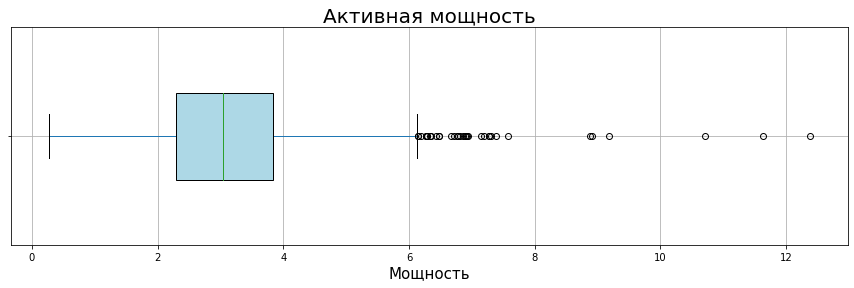

In [100]:
data.boxplot(column=['active_power'], figsize=(15, 4), vert=False, patch_artist=True, \
        boxprops=dict(facecolor='lightblue'), widths=0.4).set_yticklabels([])
plt.grid(True)
plt.title('Активная мощность', fontsize=20)
plt.ylabel('')
plt.xlabel('Мощность', fontsize=15)
plt.show()

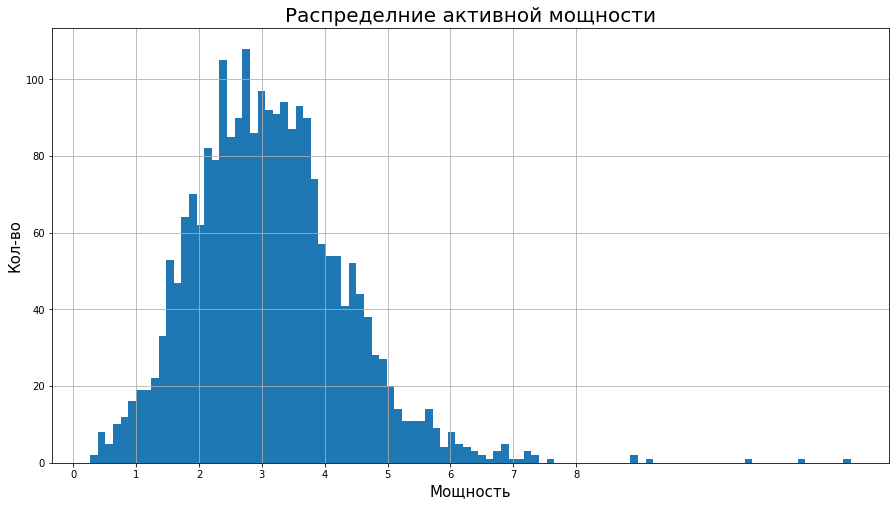

In [104]:
data['active_power'].hist(bins=100, figsize=(15,8))
plt.title('Распределние активной мощности', fontsize=20)
plt.ylabel('Кол-во', fontsize=15)
plt.xlabel('Мощность', fontsize=15)
plt.xticks(range(0, 9))
plt.show()

In [105]:
data['active_power'].describe().round(2)

count    2329.00
mean        3.13
std         1.22
min         0.27
25%         2.30
50%         3.04
75%         3.83
max        12.38
Name: active_power, dtype: float64

Среднее значение составляет 3.12, медиана - 3.02. Межквартильный интервал находится в диапазоне от 2.29 до 3.83. Распределение близко к нормальному с небольшим количеством выбросов справа.

### Реактивная мощность

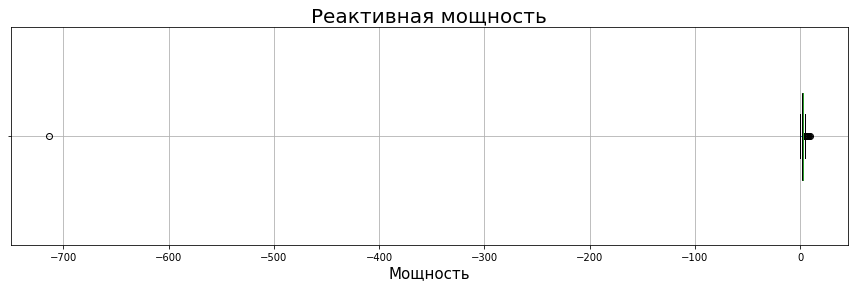

In [106]:
data.boxplot(column=['reactive_power'], figsize=(15, 4), vert=False, patch_artist=True, \
        boxprops=dict(facecolor='lightblue'), widths=0.4).set_yticklabels([])
plt.grid(True)
plt.title('Реактивная мощность', fontsize=20)
plt.ylabel('')
plt.xlabel('Мощность', fontsize=15)
plt.show()

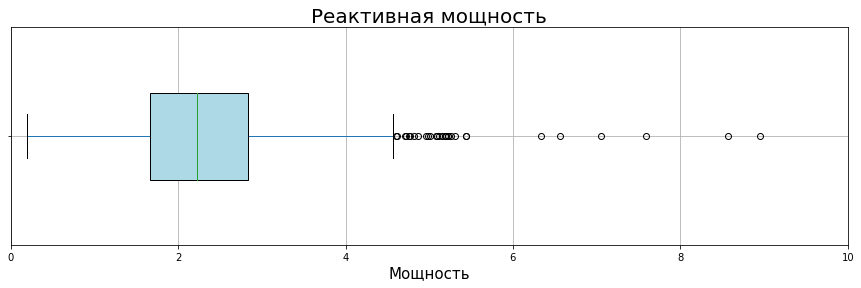

In [107]:
data.boxplot(column=['reactive_power'], figsize=(15, 4), vert=False, patch_artist=True, \
        boxprops=dict(facecolor='lightblue'), widths=0.4).set_yticklabels([])
plt.grid(True)
plt.title('Реактивная мощность', fontsize=20)
plt.ylabel('')
plt.xlabel('Мощность', fontsize=15)
plt.xlim(0, 10)
plt.show()

In [108]:
data.query('reactive_power < 0')['reactive_power'].count()

1

Удалим записи со значениями реактивной мощности менее 0.

In [109]:
ind_drop_reactive_power = data.query('reactive_power < 0').index

In [110]:
data.drop(ind_drop_reactive_power, inplace=True)

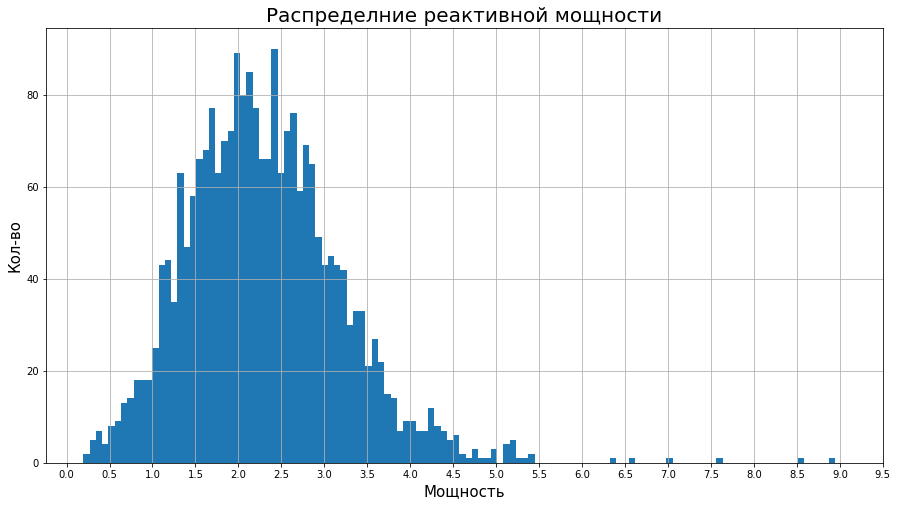

In [111]:
data['reactive_power'].hist(bins=120, figsize=(15,8))
plt.title('Распределние реактивной мощности', fontsize=20)
plt.ylabel('Кол-во', fontsize=15)
plt.xlabel('Мощность', fontsize=15)
plt.xticks([n/10 for n in range(0, 100, 5)])
plt.show()

In [112]:
data['reactive_power'].describe().round(2)

count    2328.00
mean        2.30
std         0.90
min         0.20
25%         1.67
50%         2.23
75%         2.83
max         8.95
Name: reactive_power, dtype: float64

Среднее значение составляет 2.30, медиана - 2.23. Межквартильный интервал от 1.67 до 2.83.

### Полная мощность

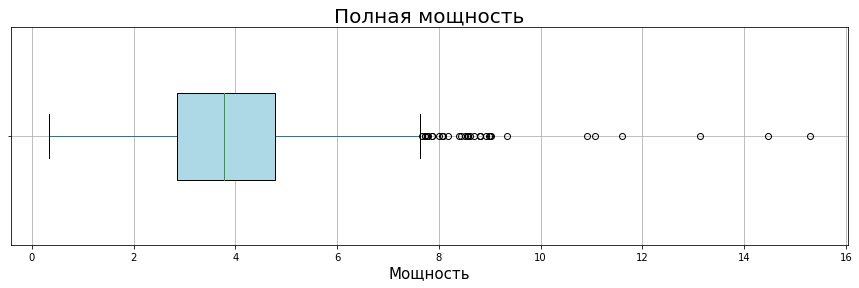

In [113]:
data.boxplot(column=['full_power'], figsize=(15, 4), vert=False, patch_artist=True, \
        boxprops=dict(facecolor='lightblue'), widths=0.4).set_yticklabels([])
plt.grid(True)
plt.title('Полная мощность', fontsize=20)
plt.ylabel('')
plt.xlabel('Мощность', fontsize=15)
plt.show()

По данному признаку выбросы удалять не будем т.к. супер-выбросы отсутствуют, а присутствующие обусловлены за счет расчетов из активной и реактивной мощностей.

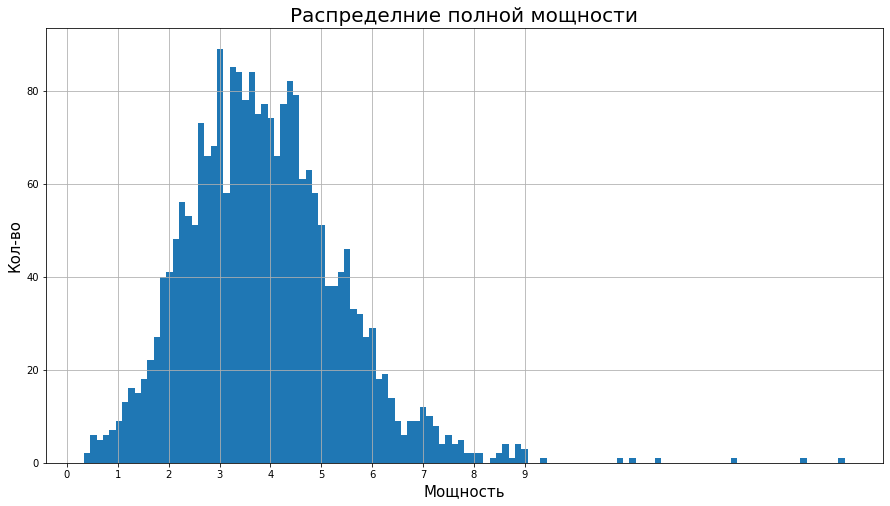

In [114]:
data['full_power'].hist(bins=120, figsize=(15,8))
plt.title('Распределние полной мощности', fontsize=20)
plt.ylabel('Кол-во', fontsize=15)
plt.xlabel('Мощность', fontsize=15)
plt.xticks(range(0, 10))
plt.show()

In [115]:
data['full_power'].describe().round(2)

count    2328.00
mean        3.89
std         1.52
min         0.33
25%         2.84
50%         3.77
75%         4.77
max        15.29
Name: full_power, dtype: float64

Среднее значение составляет 3.85, медиана - 3.75. Межквартильный интервал от 2.83 до 4.76.

### Длительность нагрева

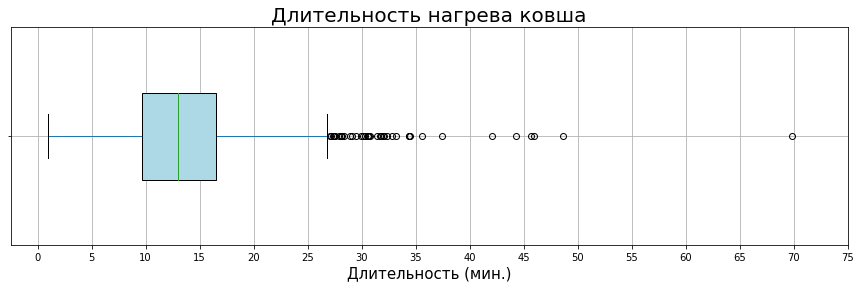

In [116]:
data.boxplot(column=['heating_longevity'], figsize=(15, 4), vert=False, patch_artist=True, \
        boxprops=dict(facecolor='lightblue'), widths=0.4).set_yticklabels([])
plt.grid(True)
plt.title('Длительность нагрева ковша', fontsize=20)
plt.ylabel('')
plt.xlabel('Длительность (мин.)', fontsize=15)
plt.xticks(range(0, 80, 5))
plt.show()

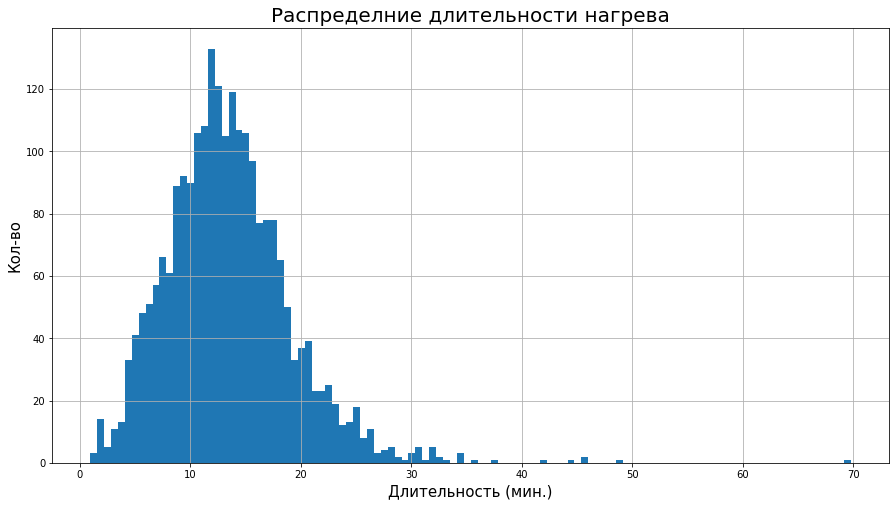

In [121]:
data['heating_longevity'].hist(bins=110, figsize=(15,8))
plt.title('Распределние длительности нагрева', fontsize=20)
plt.ylabel('Кол-во', fontsize=15)
plt.xlabel('Длительность (мин.)', fontsize=15)
plt.show()

In [122]:
data['heating_longevity'].describe().round(2)

count    2328.00
mean       13.46
std         5.68
min         0.95
25%         9.68
50%        12.97
75%        16.55
max        69.82
Name: heating_longevity, dtype: float64

Среднее значение составляет 13.46, медиана - 12.97. Межквартильный интервал составляет от 9.68 до 16.55.

### Газ

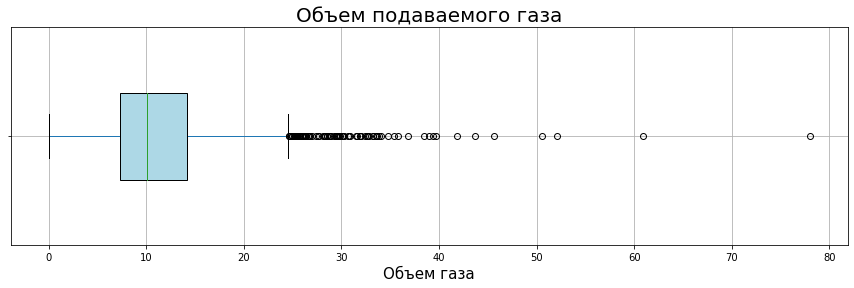

In [123]:
data.boxplot(column=['gas'], figsize=(15, 4), vert=False, patch_artist=True, \
        boxprops=dict(facecolor='lightblue'), widths=0.4).set_yticklabels([])
plt.grid(True)
plt.title('Объем подаваемого газа', fontsize=20)
plt.ylabel('')
plt.xlabel('Объем газа', fontsize=15)
plt.show()

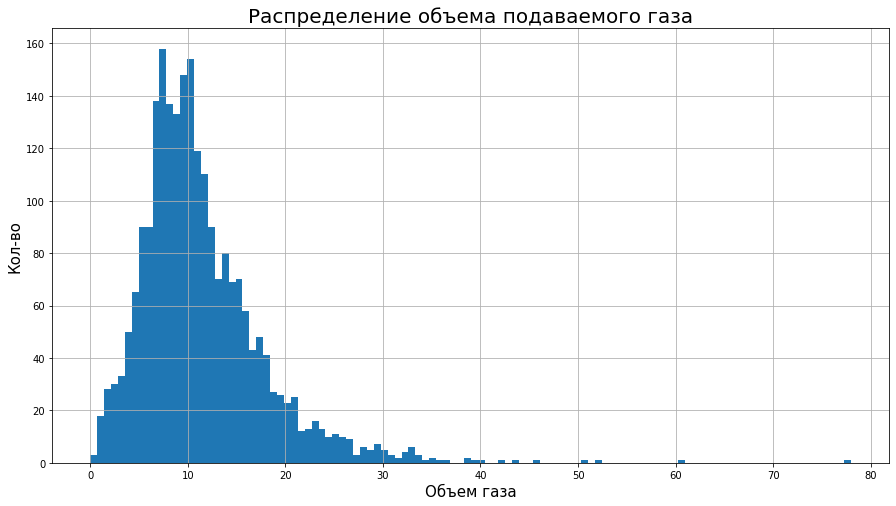

In [128]:
data['gas'].hist(bins=110, figsize=(15,8))
plt.title('Распределение объема подаваемого газа', fontsize=20)
plt.ylabel('Кол-во', fontsize=15)
plt.xlabel('Объем газа', fontsize=15)
plt.show()

In [129]:
data['gas'].describe().round(2)

count    2328.00
mean       11.38
std         6.39
min         0.01
25%         7.28
50%        10.10
75%        14.22
max        78.00
Name: gas, dtype: float64

Среднее значение составляет 11.38, медиана - 10.10. Межквартильный интревал от 7.28 до 14.22.

### Начальная температура

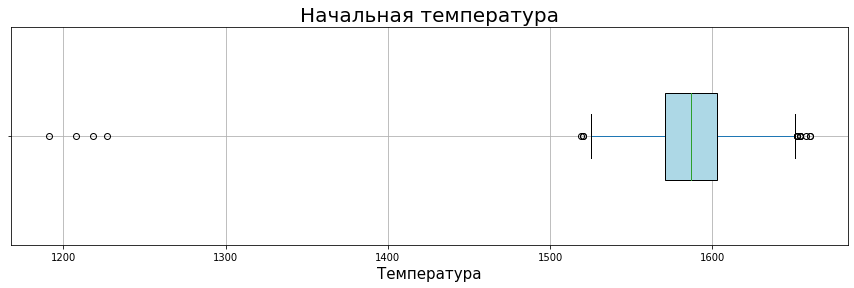

In [130]:
data.boxplot(column=['first_temperature'], figsize=(15, 4), vert=False, patch_artist=True, \
        boxprops=dict(facecolor='lightblue'), widths=0.4).set_yticklabels([])
plt.grid(True)
plt.title('Начальная температура', fontsize=20)
plt.ylabel('')
plt.xlabel('Температура', fontsize=15)
plt.show()

In [131]:
data.query('first_temperature < 1400')['first_temperature'].count()

4

Удалим записи со значениями начальной температуры менее 1400.

In [132]:
ind_drop_first_temp = data.query('first_temperature < 1400').index

In [133]:
data.drop(ind_drop_first_temp, inplace=True)

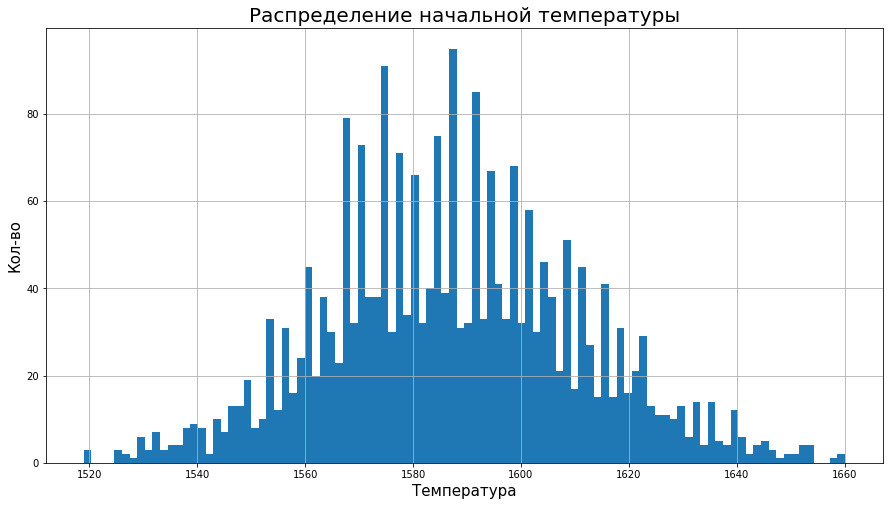

In [134]:
data['first_temperature'].hist(bins=100, figsize=(15,8))
plt.title('Распределение начальной температуры', fontsize=20)
plt.ylabel('Кол-во', fontsize=15)
plt.xlabel('Температура', fontsize=15)
plt.show()

In [135]:
data['first_temperature'].describe().round()

count    2324.0
mean     1587.0
std        24.0
min      1519.0
25%      1571.0
50%      1587.0
75%      1603.0
max      1660.0
Name: first_temperature, dtype: float64

Среднее значение и медиана равны 1587. Межквартильный интервал составляет от 1571 до 1603.

### Конечная температура

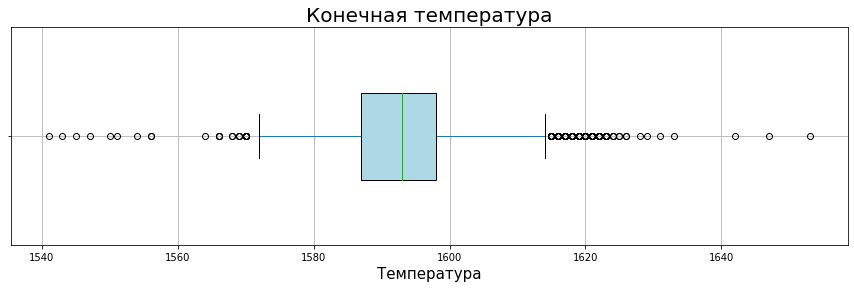

In [136]:
data.boxplot(column=['last_temperature'], figsize=(15, 4), vert=False, patch_artist=True, \
        boxprops=dict(facecolor='lightblue'), widths=0.4).set_yticklabels([])
plt.grid(True)
plt.title('Конечная температура', fontsize=20)
plt.ylabel('')
plt.xlabel('Температура', fontsize=15)
plt.show()

По данному признаку записи удалять не будем.

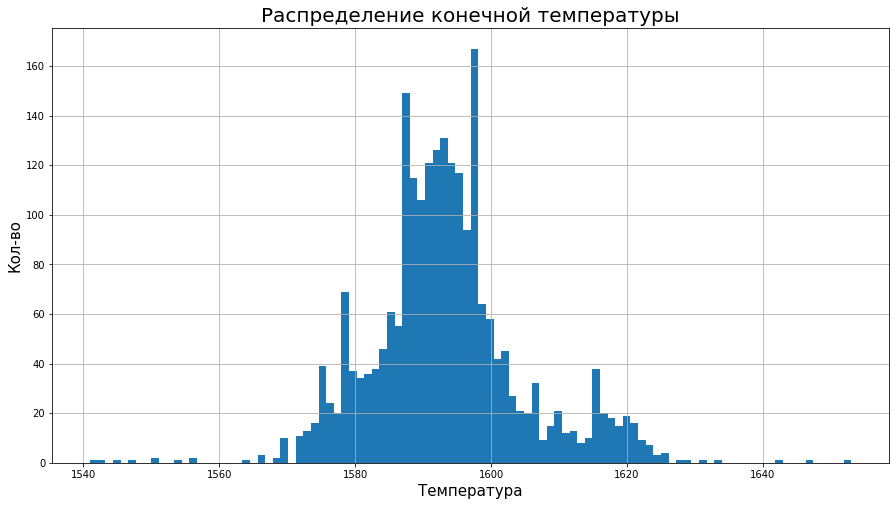

In [137]:
data['last_temperature'].hist(bins=100, figsize=(15,8))
plt.title('Распределение конечной температуры', fontsize=20)
plt.ylabel('Кол-во', fontsize=15)
plt.xlabel('Температура', fontsize=15)
plt.show()

In [138]:
data['last_temperature'].describe().round()

count    2324.0
mean     1593.0
std        11.0
min      1541.0
25%      1587.0
50%      1593.0
75%      1598.0
max      1653.0
Name: last_temperature, dtype: float64

Среднее значение и медиана равны 1593. Межквартильный интервал от 1587 до 1598.

### Объем подаваемого сыпучего материала

In [139]:
bulk_list = ['bulk_1', 'bulk_2', 'bulk_3', 'bulk_4', 'bulk_5', 'bulk_6', 'bulk_7', \
             'bulk_8', 'bulk_9', 'bulk_10', 'bulk_11', 'bulk_12', 'bulk_13','bulk_14', 'bulk_15']

In [140]:
bulk_count = []

In [141]:
for bulk in bulk_list:
    bulk_count.append(data[bulk].ne(0).sum())

In [142]:
bulk_data = {
    'bulk_name': bulk_list,
    'bulk_count': bulk_count
}

In [143]:
bulk_df = pd.DataFrame(bulk_data)

In [144]:
bulk_df['percent'] = (bulk_df['bulk_count'] / bulk_df['bulk_count'].sum()).round(3)*100

In [145]:
bulk_df

bulk_name  bulk_count  percent
0     bulk_1         199      2.4
1     bulk_2          13      0.2
2     bulk_3         958     11.5
3     bulk_4         811      9.7
4     bulk_5          53      0.6
5     bulk_6         437      5.2
6     bulk_7          13      0.2
7     bulk_8           1      0.0
8     bulk_9          13      0.2
9    bulk_10         143      1.7
10   bulk_11         130      1.6
11   bulk_12        1809     21.7
12   bulk_13          14      0.2
13   bulk_14        2064     24.7
14   bulk_15        1696     20.3

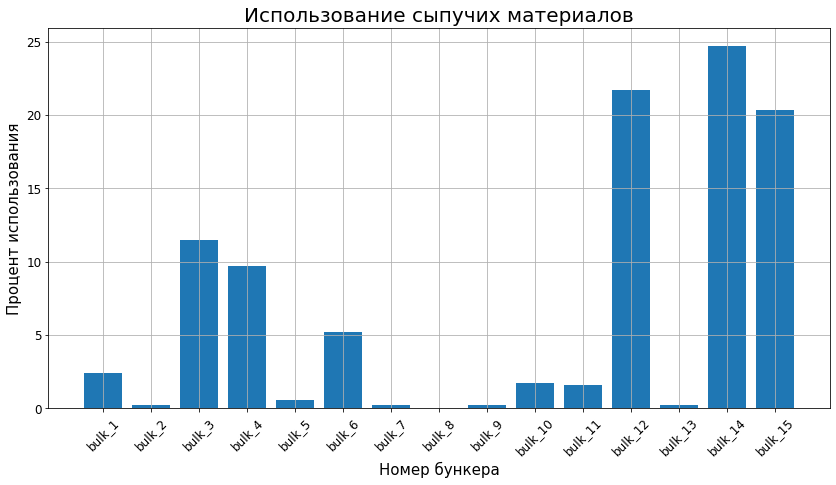

In [146]:
plt.figure(figsize=(14,7))
plt.bar(bulk_df['bulk_name'], bulk_df['percent'])
plt.title('Использование сыпучих материалов', fontsize=20)
plt.xticks(fontsize=12, rotation=45)
plt.yticks(fontsize=12)
plt.ylabel('Процент использования', fontsize=15)
plt.xlabel('Номер бункера', fontsize=15)
plt.grid(True)
plt.show()

Чаще остальных подаются материалы из ковшей №14, №12, №15.

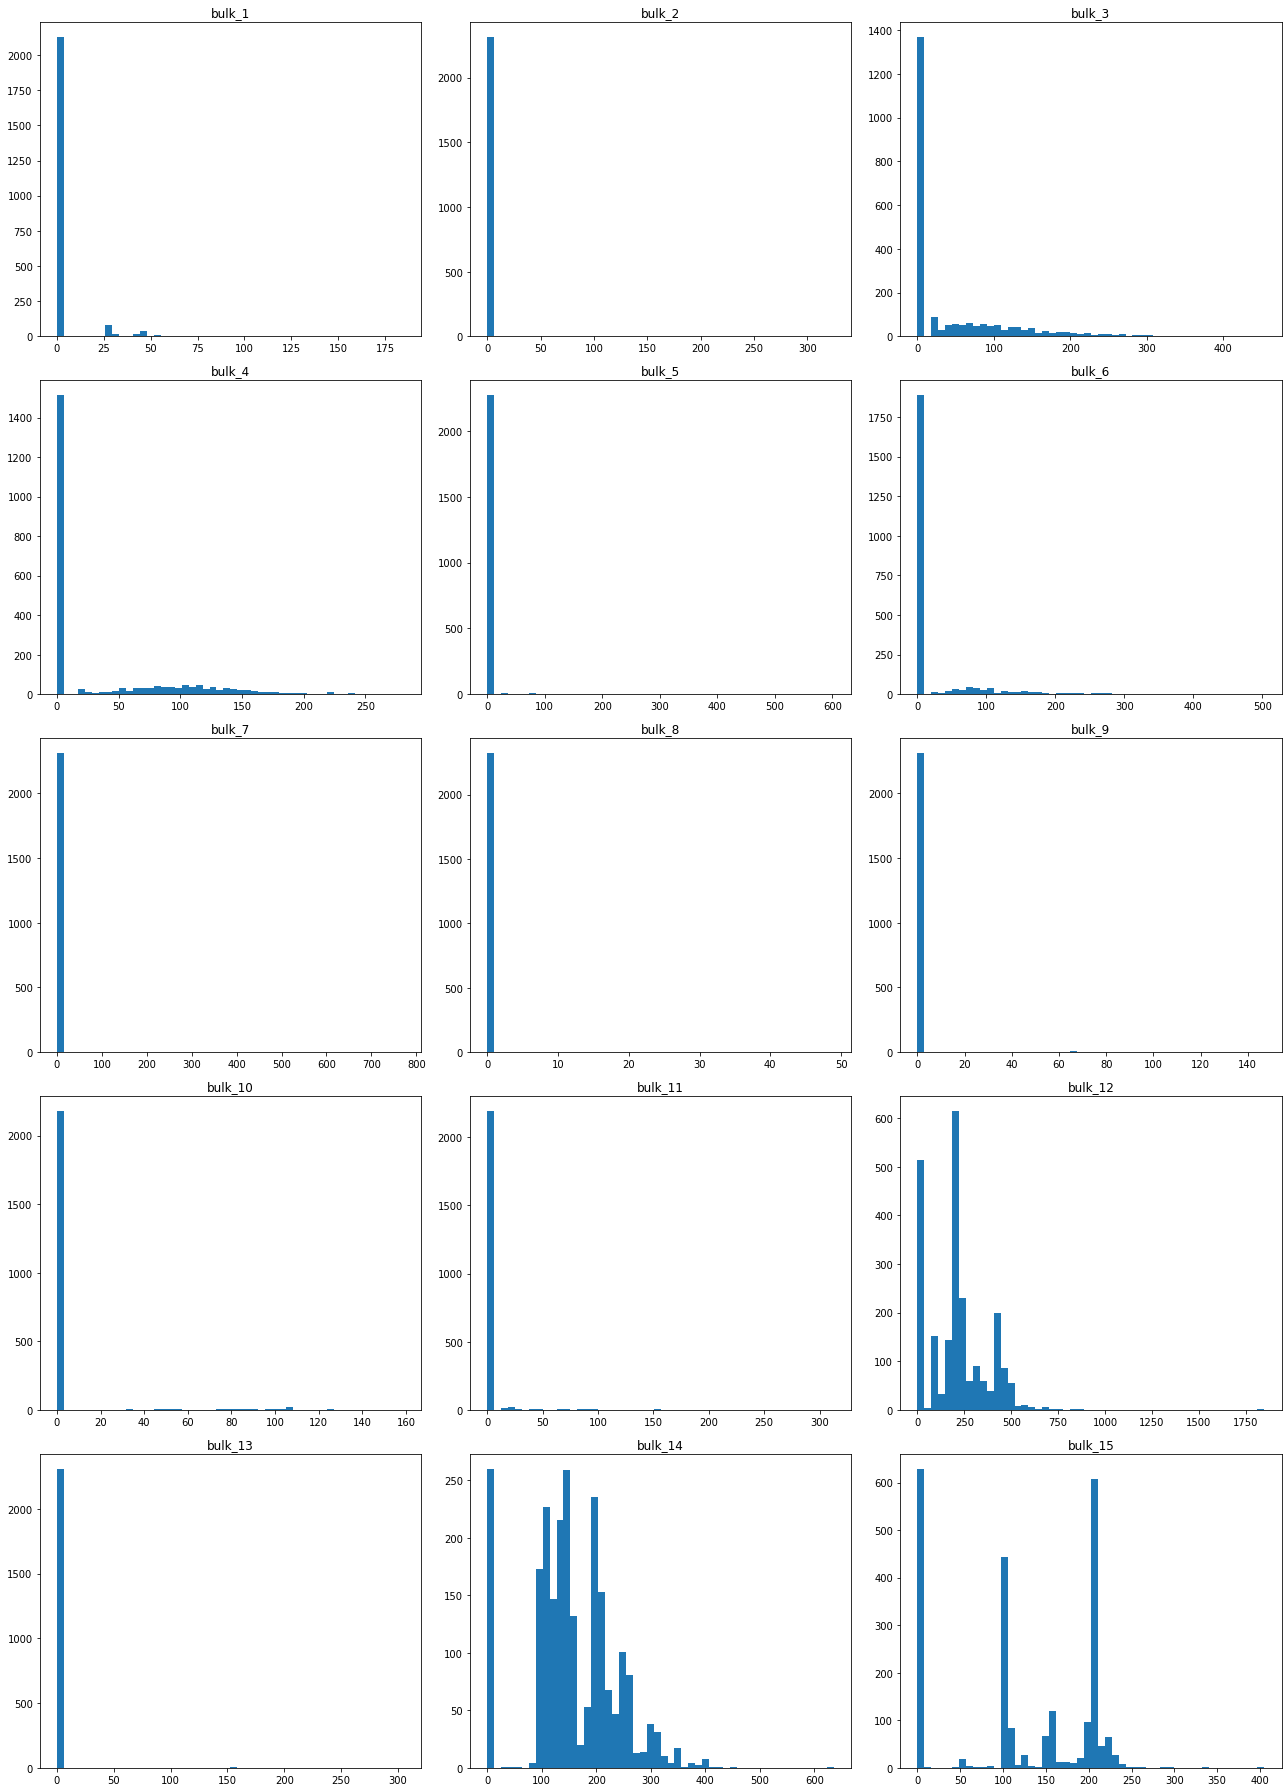

In [147]:
fig, axs = plt.subplots(5, 3, figsize=(18, 25))

for i, bulk in enumerate(bulk_list):
    row = i // 3
    col = i % 3
    axs[row, col].hist(data[bulk], bins=50)
    axs[row, col].set_title(bulk)
plt.tight_layout()
plt.show()

### Объем подаваемого проволочного материала

In [148]:
data.columns

Index(['active_power', 'reactive_power', 'heating_longevity', 'full_power',
       'bulk_1', 'bulk_2', 'bulk_3', 'bulk_4', 'bulk_5', 'bulk_6', 'bulk_7',
       'bulk_8', 'bulk_9', 'bulk_10', 'bulk_11', 'bulk_12', 'bulk_13',
       'bulk_14', 'bulk_15', 'gas', 'first_temperature', 'last_temperature',
       'wire_1', 'wire_2', 'wire_3', 'wire_4', 'wire_5', 'wire_6', 'wire_7',
       'wire_8', 'wire_9'],
      dtype='object')

In [149]:
wire_list = ['wire_1', 'wire_2', 'wire_3', 'wire_4', 'wire_5', 'wire_6', 'wire_7','wire_8', 'wire_9']

In [150]:
wire_count = []

In [151]:
for wire in wire_list:
    wire_count.append(data[wire].ne(0).sum())

In [152]:
wire_data = {
    'wire_name': wire_list,
    'wire_count': wire_count
}

In [153]:
wire_df = pd.DataFrame(wire_data)

In [154]:
wire_df['percent'] = (wire_df['wire_count'] / wire_df['wire_count'].sum()).round(3)*100

In [155]:
wire_df

wire_name  wire_count  percent
0    wire_1        2301     70.9
1    wire_2         809     24.9
2    wire_3          39      1.2
3    wire_4          12      0.4
4    wire_5           0      0.0
5    wire_6          45      1.4
6    wire_7           4      0.1
7    wire_8          13      0.4
8    wire_9          24      0.7

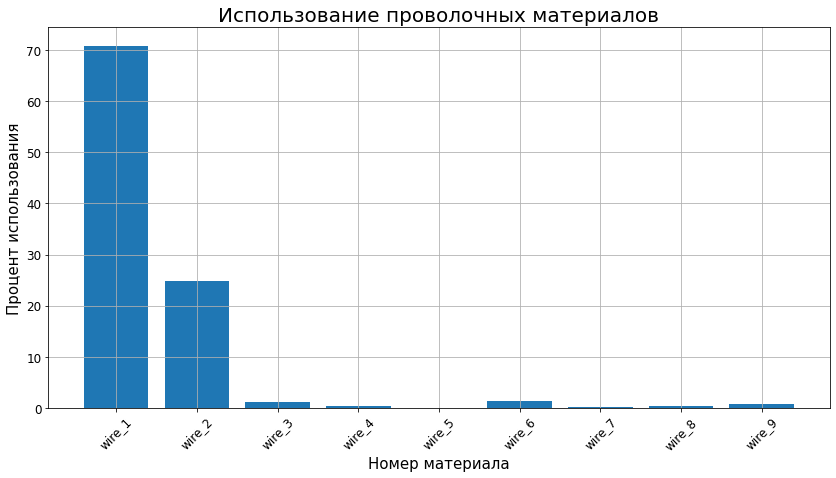

In [156]:
plt.figure(figsize=(14,7))
plt.bar(wire_df['wire_name'], wire_df['percent'])
plt.title('Использование проволочных материалов', fontsize=20)
plt.xticks(fontsize=12, rotation=45)
plt.yticks(fontsize=12)
plt.ylabel('Процент использования', fontsize=15)
plt.xlabel('Номер материала', fontsize=15)
plt.grid(True)
plt.show()

В абсолютном большинстве случаев используются первый и второй материалы - 70.7% и 24.7% соответственно.

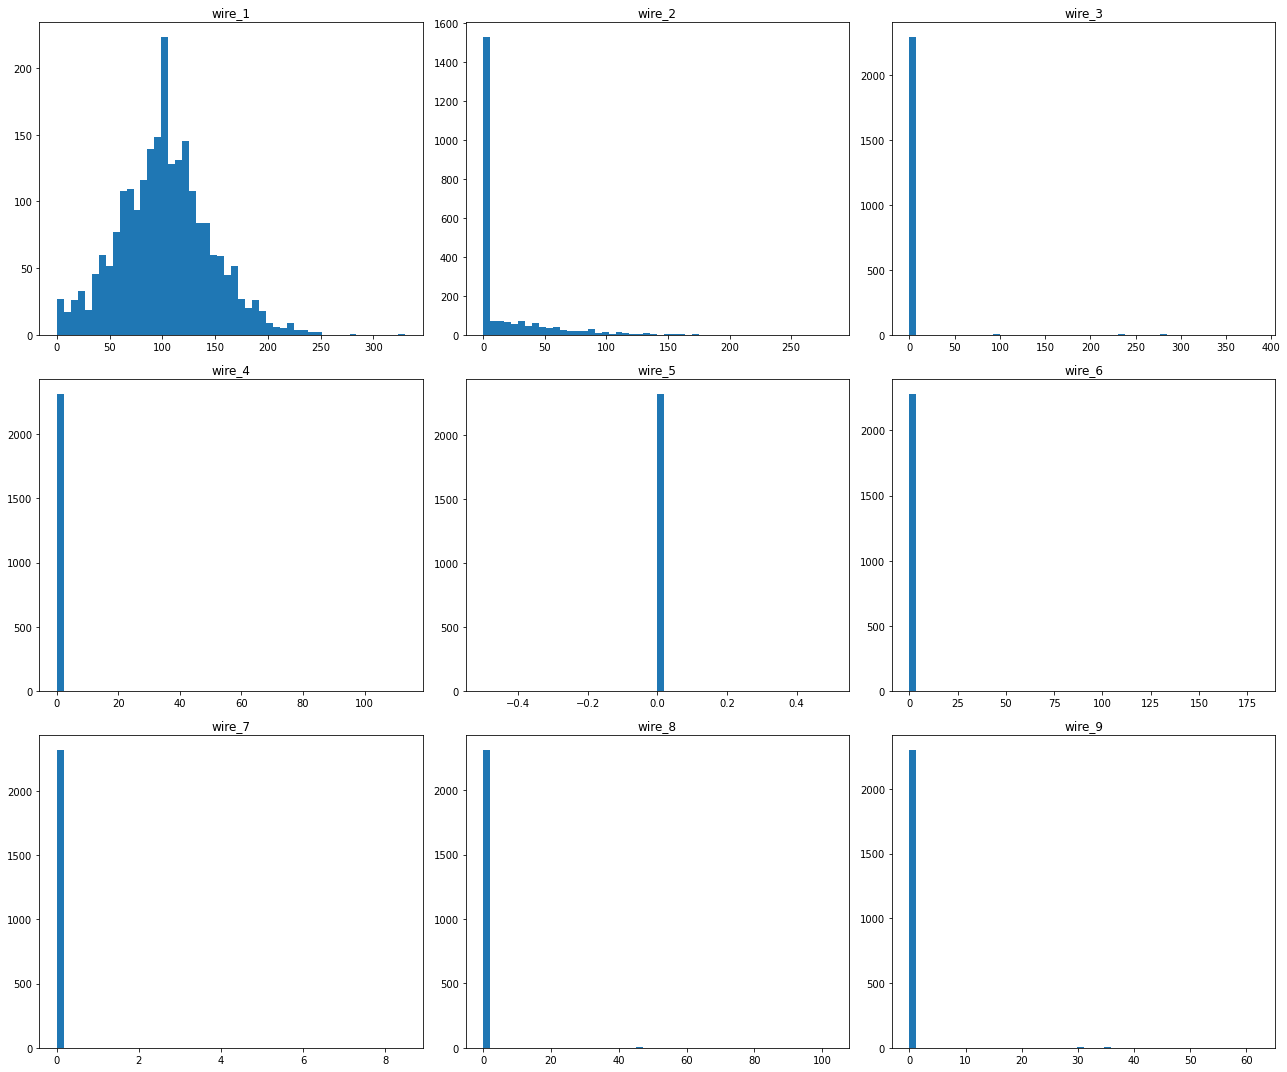

In [157]:
fig, axs = plt.subplots(3, 3, figsize=(18, 15))

for i, wire in enumerate(wire_list):
    row = i // 3
    col = i % 3
    axs[row, col].hist(data[wire], bins=50)
    axs[row, col].set_title(wire)
plt.tight_layout()
plt.show()

### Корреляционный анализ

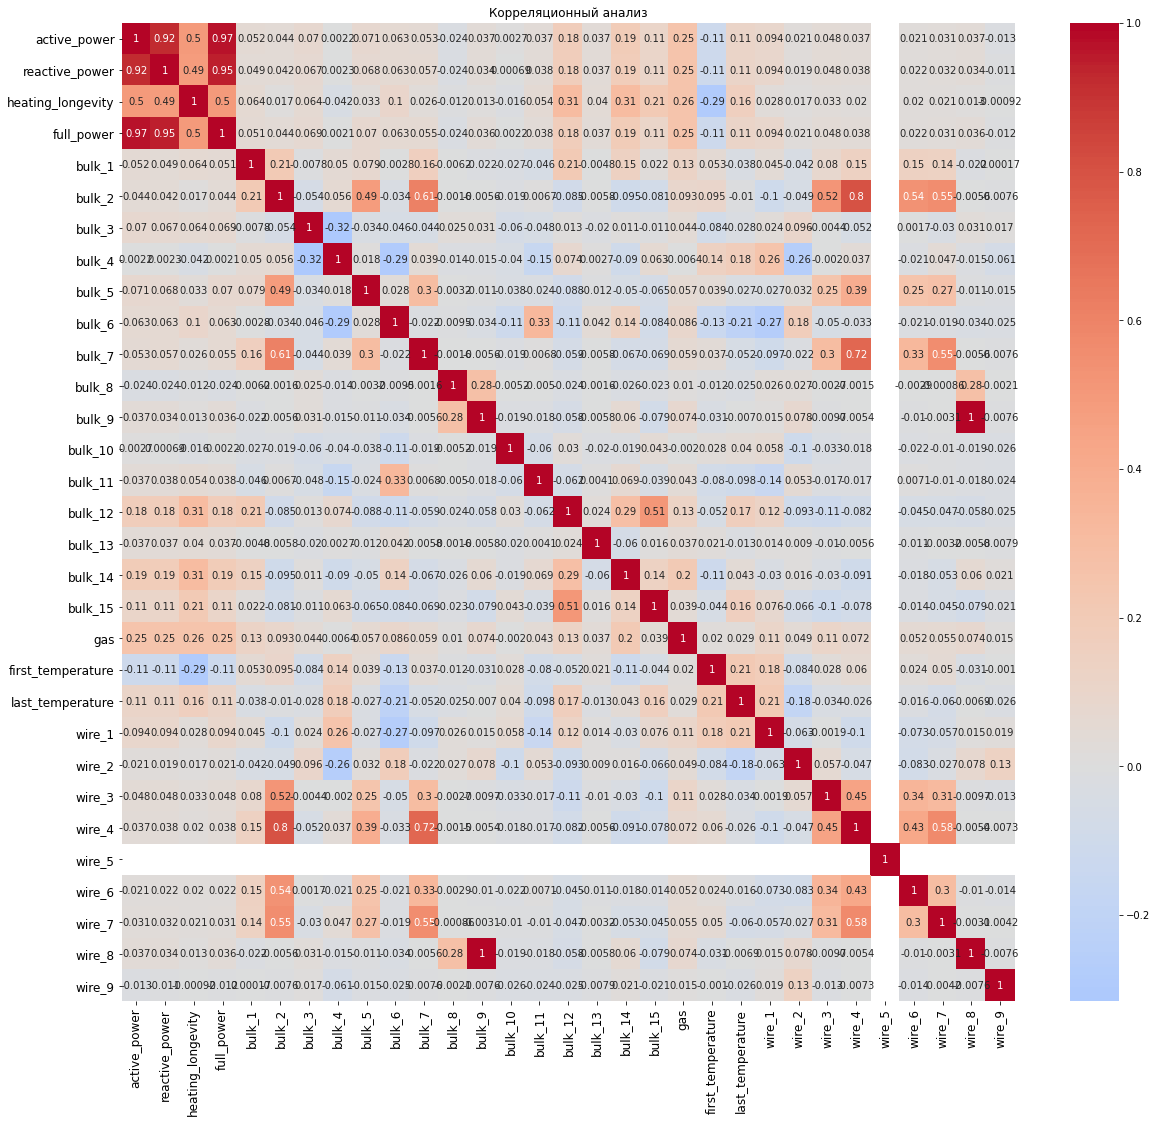

In [158]:
plt.subplots(figsize=(20, 18))
sns.heatmap(data.corr(method='kendall'), annot=True, cmap='coolwarm', center=0,)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
plt.title('Корреляционный анализ')
plt.show()

Присутствует мультиколлениарность между полной мощностью и активной и реактивной мощностями. Ее нужно будет устранить при построении линейной модели. Между целевым признаком и остальными не прослеживается сильной зависимости.

## Подготовка данных

In [160]:
clean_data = data.copy()

In [161]:
clean_data

active_power  reactive_power  heating_longevity  full_power  bulk_1  \
key                                                                         
1         3.036730        2.142821          18.300000    3.718736     0.0   
2         2.139408        1.453357          13.516667    2.588349     0.0   
3         4.063641        2.937457          10.916667    5.019223     0.0   
4         2.706489        2.056992          12.350000    3.400038     0.0   
5         2.252950        1.687991          14.483333    2.816980     0.0   
...            ...             ...                ...         ...     ...   
2495      3.168133        2.210936          12.050000    3.868721     0.0   
2496      4.174918        2.872031          15.666667    5.070316     0.0   
2497      3.605239        2.452092           9.483333    4.360918     0.0   
2498      3.202310        2.239820          12.500000    3.909917     0.0   
2499      1.737084        1.296836          14.716667    2.169252     0.0   

      bulk_2  bulk_3  bulk_4  bulk_5  bulk_6  ...  last_temperature  \
key                                           ...                     
1        0.0     0.0    43.0     0.0     0.0  ...            1613.0   
2        0.0     0.0    73.0     0.0     0.0  ...            1602.0   
3        0.0     0.0    34.0     0.0     0.0  ...            1599.0   
4        0.0     0.0    81.0     0.0     0.0  ...            1625.0   
5        0.0     0.0    78.0     0.0     0.0  ...            1602.0   
...      ...     ...     ...     ...     ...  ...               ...   
2495     0.0    21.0     0.0     0.0     0.0  ...            1591.0   
2496     0.0     0.0    63.0     0.0     0.0  ...            1591.0   
2497     0.0     0.0    85.0     0.0     0.0  ...            1589.0   
2498     0.0    90.0     0.0     0.0     0.0  ...            1594.0   
2499     0.0    47.0     0.0     0.0     0.0  ...            1603.0   

          wire_1    wire_2  wire_3  wire_4  wire_5  wire_6  wire_7  wire_8  \
key                                                                          
1      60.059998   0.00000     0.0     0.0     0.0     0.0     0.0     0.0   
2      96.052315   0.00000     0.0     0.0     0.0     0.0     0.0     0.0   
3      91.160157   0.00000     0.0     0.0     0.0     0.0     0.0     0.0   
4      89.063515   0.00000     0.0     0.0     0.0     0.0     0.0     0.0   
5      89.238236   9.11456     0.0     0.0     0.0     0.0     0.0     0.0   
...          ...       ...     ...     ...     ...     ...     ...     ...   
2495   89.150879   0.00000     0.0     0.0     0.0     0.0     0.0     0.0   
2496  114.179527   0.00000     0.0     0.0     0.0     0.0     0.0     0.0   
2497   94.086723   9.04800     0.0     0.0     0.0     0.0     0.0     0.0   
2498  118.110717   0.00000     0.0     0.0     0.0     0.0     0.0     0.0   
2499  110.160958  50.00528     0.0     0.0     0.0     0.0     0.0     0.0   

      wire_9  
key           
1        0.0  
2        0.0  
3        0.0  
4        0.0  
5        0.0  
...      ...  
2495     0.0  
2496     0.0  
2497     0.0  
2498     0.0  
2499     0.0  

[2324 rows x 31 columns]

In [163]:
clean_data.columns

Index(['active_power', 'reactive_power', 'heating_longevity', 'full_power',
       'bulk_1', 'bulk_2', 'bulk_3', 'bulk_4', 'bulk_5', 'bulk_6', 'bulk_7',
       'bulk_8', 'bulk_9', 'bulk_10', 'bulk_11', 'bulk_12', 'bulk_13',
       'bulk_14', 'bulk_15', 'gas', 'first_temperature', 'last_temperature',
       'wire_1', 'wire_2', 'wire_3', 'wire_4', 'wire_5', 'wire_6', 'wire_7',
       'wire_8', 'wire_9'],
      dtype='object')

In [164]:
X = clean_data.drop('last_temperature', axis=1)

In [165]:
y = clean_data['last_temperature']

In [166]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    random_state=RANDOM_STATE,
    test_size=TEST_SIZE
)

In [168]:
num_columns = ['active_power', 'reactive_power', 'heating_longevity', 'full_power', \
               'bulk_1', 'bulk_2', 'bulk_3', 'bulk_4', 'bulk_5', 'bulk_6', 'bulk_7', \
               'bulk_8', 'bulk_9', 'bulk_10', 'bulk_11', 'bulk_12', 'bulk_13','bulk_14', \
               'bulk_15', 'gas', 'first_temperature', 'wire_1', 'wire_2','wire_3', \
               'wire_4', 'wire_5', 'wire_6', 'wire_7', 'wire_8', 'wire_9']

In [1]:
data_preprocessor = ColumnTransformer(
    [
        ('num', StandardScaler(), num_columns)
    ],
    remainder='passthrough'
)

NameError: name 'ColumnTransformer' is not defined

In [170]:
pipe_final = Pipeline(
    [
        ('preprocessor', data_preprocessor),
        ('models', LinearRegression())
    ]
)

## Обучение моделей

### Линейная регрессия

In [171]:
X_train_lin = X_train.copy()

In [172]:
X_train_lin.drop(columns=['active_power', 'reactive_power'], inplace=True)

In [209]:
X

active_power  reactive_power  heating_longevity  full_power  bulk_1  \
key                                                                         
1         3.036730        2.142821          18.300000    3.718736     0.0   
2         2.139408        1.453357          13.516667    2.588349     0.0   
3         4.063641        2.937457          10.916667    5.019223     0.0   
4         2.706489        2.056992          12.350000    3.400038     0.0   
5         2.252950        1.687991          14.483333    2.816980     0.0   
...            ...             ...                ...         ...     ...   
2495      3.168133        2.210936          12.050000    3.868721     0.0   
2496      4.174918        2.872031          15.666667    5.070316     0.0   
2497      3.605239        2.452092           9.483333    4.360918     0.0   
2498      3.202310        2.239820          12.500000    3.909917     0.0   
2499      1.737084        1.296836          14.716667    2.169252     0.0   

      bulk_2  bulk_3  bulk_4  bulk_5  bulk_6  ...  first_temperature  \
key                                           ...                      
1        0.0     0.0    43.0     0.0     0.0  ...             1571.0   
2        0.0     0.0    73.0     0.0     0.0  ...             1581.0   
3        0.0     0.0    34.0     0.0     0.0  ...             1596.0   
4        0.0     0.0    81.0     0.0     0.0  ...             1601.0   
5        0.0     0.0    78.0     0.0     0.0  ...             1576.0   
...      ...     ...     ...     ...     ...  ...                ...   
2495     0.0    21.0     0.0     0.0     0.0  ...             1570.0   
2496     0.0     0.0    63.0     0.0     0.0  ...             1554.0   
2497     0.0     0.0    85.0     0.0     0.0  ...             1571.0   
2498     0.0    90.0     0.0     0.0     0.0  ...             1591.0   
2499     0.0    47.0     0.0     0.0     0.0  ...             1569.0   

          wire_1    wire_2  wire_3  wire_4  wire_5  wire_6  wire_7  wire_8  \
key                                                                          
1      60.059998   0.00000     0.0     0.0     0.0     0.0     0.0     0.0   
2      96.052315   0.00000     0.0     0.0     0.0     0.0     0.0     0.0   
3      91.160157   0.00000     0.0     0.0     0.0     0.0     0.0     0.0   
4      89.063515   0.00000     0.0     0.0     0.0     0.0     0.0     0.0   
5      89.238236   9.11456     0.0     0.0     0.0     0.0     0.0     0.0   
...          ...       ...     ...     ...     ...     ...     ...     ...   
2495   89.150879   0.00000     0.0     0.0     0.0     0.0     0.0     0.0   
2496  114.179527   0.00000     0.0     0.0     0.0     0.0     0.0     0.0   
2497   94.086723   9.04800     0.0     0.0     0.0     0.0     0.0     0.0   
2498  118.110717   0.00000     0.0     0.0     0.0     0.0     0.0     0.0   
2499  110.160958  50.00528     0.0     0.0     0.0     0.0     0.0     0.0   

      wire_9  
key           
1        0.0  
2        0.0  
3        0.0  
4        0.0  
5        0.0  
...      ...  
2495     0.0  
2496     0.0  
2497     0.0  
2498     0.0  
2499     0.0  

[2324 rows x 30 columns]

In [173]:
num_columns_lin = ['heating_longevity', 'full_power', \
               'bulk_1', 'bulk_2', 'bulk_3', 'bulk_4', 'bulk_5', 'bulk_6', 'bulk_7', \
               'bulk_8', 'bulk_9', 'bulk_10', 'bulk_11', 'bulk_12', 'bulk_13','bulk_14', \
               'bulk_15', 'gas', 'first_temperature', 'wire_1', 'wire_2','wire_3', \
               'wire_4', 'wire_5', 'wire_6', 'wire_7', 'wire_8', 'wire_9']

In [174]:
data_preprocessor_lin = ColumnTransformer(
    [
        ('num', StandardScaler(), num_columns_lin)
    ],
    remainder='passthrough'
)

In [175]:
pipe_final_lin = Pipeline(
    [
        ('preprocessor', data_preprocessor_lin),
        ('models', LinearRegression())
    ]
)

In [176]:
param_distributions_lin = [
    {
        'models': [LinearRegression()],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']
    },
    {
        'models': [Ridge()], 
        'models__alpha': [1, 2, 3],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']
    } , 
    {
        'models': [Lasso()], 
        'models__alpha': [1, 2, 3],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']
    }, 
    {
        'models': [ElasticNet()], 
        'models__alpha': [1, 2, 3], 
        'models__l1_ratio': [0, 0.25, 0.5, 0.75, 1.0],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']
    }
]

In [177]:
lin_randomized_search = RandomizedSearchCV(
    pipe_final_lin,
    param_distributions = param_distributions_lin,
    scoring= 'neg_mean_absolute_error',
    random_state=RANDOM_STATE,
    n_jobs=-1
)

In [178]:
lin_randomized_search.fit(X_train_lin, y_train)

/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.559e+04, tolerance: 1.718e+01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.046e+04, tolerance: 1.817e+01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.

RandomizedSearchCV(estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('num',
                                                                               StandardScaler(),
                                                                               ['heating_longevity',
                                                                                'full_power',
                                                                                'bulk_1',
                                                                                'bulk_2',
                                                                                'bulk_3',
                                                                                'bulk_4',
                                                                                'bulk_5',
                                                                                'bulk_6',
                                                                                'bulk_7',
                                                                                'bulk_8',
                                                                                'bulk_9',
                                                                                'bulk_10',
                                                                                'bulk_11',
                                                                                'bulk_12',
                                                                                'bulk_13',
                                                                                'bulk_14',
                                                                                'bulk_15',
                                                                                'gas',
                                                                                'first_temperature',
                                                                                'wire_1'...
                                        {'models': [Lasso()],
                                         'models__alpha': [1, 2, 3],
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler(),
                                                               RobustScaler(),
                                                               'passthrough']},
                                        {'models': [ElasticNet()],
                                         'models__alpha': [1, 2, 3],
                                         'models__l1_ratio': [0, 0.25, 0.5,
                                                              0.75, 1.0],
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler(),
                                                               RobustScaler(),
                                                               'passthrough']}],
                   random_state=80424, scoring='neg_mean_absolute_error')

In [179]:
lin_randomized_search.best_params_

{'preprocessor__num': RobustScaler(), 'models__alpha': 1, 'models': Ridge()}

In [180]:
lin_randomized_search.best_score_.round(2)

-6.45

### Дерево принятия решений

In [181]:
param_distributions_tree = [
    {
        'models': [DecisionTreeRegressor(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 11),
        'models__min_samples_split': range(2, 10),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']
    }
]

In [182]:
tree_randomized_search = RandomizedSearchCV(
    pipe_final,
    param_distributions = param_distributions_tree,
    scoring='neg_mean_absolute_error',
    random_state=RANDOM_STATE,
    n_jobs=-1,
    error_score='raise'
)

In [183]:
tree_randomized_search.fit(X_train, y_train)

RandomizedSearchCV(error_score='raise',
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('num',
                                                                               StandardScaler(),
                                                                               ['active_power',
                                                                                'reactive_power',
                                                                                'heating_longevity',
                                                                                'full_power',
                                                                                'bulk_1',
                                                                                'bulk_2',
                                                                                'bulk_3',
                                                                                'bulk_4',
                                                                                'bulk_5',
                                                                                'bulk_6',
                                                                                'bulk_7',
                                                                                'bulk_8',
                                                                                'bulk_9',
                                                                                'bulk_10',
                                                                                'bulk_11',
                                                                                'bulk_12',
                                                                                'bulk_13',
                                                                                'b...
                                                                                'wire_8',
                                                                                'wire_9'])])),
                                             ('models', LinearRegression())]),
                   n_jobs=-1,
                   param_distributions=[{'models': [DecisionTreeRegressor(random_state=80424)],
                                         'models__max_depth': range(2, 11),
                                         'models__min_samples_split': range(2, 10),
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler(),
                                                               RobustScaler(),
                                                               'passthrough']}],
                   random_state=80424, scoring='neg_mean_absolute_error')

In [184]:
tree_randomized_search.best_params_

{'preprocessor__num': MinMaxScaler(),
 'models__min_samples_split': 3,
 'models__max_depth': 8,
 'models': DecisionTreeRegressor(random_state=80424)}

In [185]:
tree_randomized_search.best_score_.round(2)

-7.47

In [186]:
tree_features = tree_randomized_search.best_estimator_._final_estimator.feature_importances_

In [187]:
tree_features

array([0.02056798, 0.0156557 , 0.21995734, 0.00187863, 0.0140798 ,
       0.        , 0.00880904, 0.00626172, 0.        , 0.06665554,
       0.        , 0.        , 0.        , 0.00929949, 0.00727479,
       0.00594764, 0.        , 0.04847938, 0.04655855, 0.03191405,
       0.29576866, 0.08221852, 0.04970079, 0.02140767, 0.        ,
       0.        , 0.01566237, 0.03190231, 0.        , 0.        ])

### LGBMRegressor

In [188]:
param_distributions_lgb= [
    {
        'models': [LGBMRegressor()],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']
    }
]

In [189]:
lgb_randomized_search = RandomizedSearchCV(
    pipe_final,
    param_distributions = param_distributions_lgb,
    scoring='neg_mean_absolute_error',
    random_state=RANDOM_STATE,
    n_jobs=-1
)

In [190]:
lgb_randomized_search.fit(X_train, y_train)

/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_search.py:318: UserWarning: The total space of parameters 4 is smaller than n_iter=10. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


RandomizedSearchCV(estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('num',
                                                                               StandardScaler(),
                                                                               ['active_power',
                                                                                'reactive_power',
                                                                                'heating_longevity',
                                                                                'full_power',
                                                                                'bulk_1',
                                                                                'bulk_2',
                                                                                'bulk_3',
                                                                                'bulk_4',
                                                                                'bulk_5',
                                                                                'bulk_6',
                                                                                'bulk_7',
                                                                                'bulk_8',
                                                                                'bulk_9',
                                                                                'bulk_10',
                                                                                'bulk_11',
                                                                                'bulk_12',
                                                                                'bulk_13',
                                                                                'bulk_14',
                                                                                'bulk_15',
                                                                                'gas',
                                                                                'first_temperature',
                                                                                'wire_1',
                                                                                'wire_2',
                                                                                'wire_3',
                                                                                'wire_4',
                                                                                'wire_5',
                                                                                'wire_6',
                                                                                'wire_7',
                                                                                'wire_8',
                                                                                'wire_9'])])),
                                             ('models', LinearRegression())]),
                   n_jobs=-1,
                   param_distributions=[{'models': [LGBMRegressor()],
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler(),
                                                               RobustScaler(),
                                                               'passthrough']}],
                   random_state=80424, scoring='neg_mean_absolute_error')

In [191]:
lgb_randomized_search.best_params_

{'preprocessor__num': MinMaxScaler(), 'models': LGBMRegressor()}

In [192]:
lgb_randomized_search.best_score_.round(2)

-6.45

In [193]:
lgb_randomized_search.best_estimator_._final_estimator.feature_importances_

array([149, 167, 352,  90,  39,   0, 125,  81,  20, 151,   0,   0,   0,
         1,  43, 187,   0, 291, 137, 289, 422, 304, 100,  46,   0,   0,
         6,   0,   0,   0], dtype=int32)

### CatBoost

In [194]:
param_distributions_cat= [
    {
        'models': [cb.CatBoostRegressor()],
        'models__l2_leaf_reg': range(3, 10),
        'models__sampling_frequency': ['PerTree', 'PerTreeLevel'],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']
    }
]

In [195]:
cat_randomized_search = RandomizedSearchCV(
    pipe_final,
    param_distributions = param_distributions_cat,
    scoring='neg_mean_absolute_error',
    random_state=RANDOM_STATE,
    n_jobs=-1,
    error_score='raise'
)

In [196]:
cat_randomized_search.fit(X_train, y_train)

0:	learn: 11.0236840	total: 49.9ms	remaining: 49.9s
1:	learn: 10.9544816	total: 53.1ms	remaining: 26.5s
2:	learn: 10.8829233	total: 56.4ms	remaining: 18.7s
3:	learn: 10.8017246	total: 59.4ms	remaining: 14.8s
4:	learn: 10.7324669	total: 62.5ms	remaining: 12.4s
5:	learn: 10.6719755	total: 66.1ms	remaining: 11s
6:	learn: 10.6120707	total: 69.2ms	remaining: 9.82s
7:	learn: 10.5480184	total: 72.7ms	remaining: 9.01s
8:	learn: 10.4922760	total: 75.9ms	remaining: 8.36s
9:	learn: 10.4435626	total: 79.9ms	remaining: 7.91s
10:	learn: 10.3835015	total: 83.2ms	remaining: 7.48s
11:	learn: 10.3262261	total: 86.2ms	remaining: 7.1s
12:	learn: 10.2705866	total: 89.5ms	remaining: 6.79s
13:	learn: 10.2201496	total: 92.8ms	remaining: 6.53s
14:	learn: 10.1654780	total: 96.5ms	remaining: 6.34s
15:	learn: 10.1230395	total: 99.9ms	remaining: 6.14s
16:	learn: 10.0731204	total: 103ms	remaining: 5.97s
17:	learn: 10.0192112	total: 106ms	remaining: 5.8s
18:	learn: 9.9699120	total: 110ms	remaining: 5.67s
19:	learn: 

RandomizedSearchCV(error_score='raise',
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('num',
                                                                               StandardScaler(),
                                                                               ['active_power',
                                                                                'reactive_power',
                                                                                'heating_longevity',
                                                                                'full_power',
                                                                                'bulk_1',
                                                                                'bulk_2',
                                                                                'bulk_3',
                                                                                'bulk_4',
                                                                                'bulk_5',
                                                                                'bulk_6',
                                                                                'bulk_7',
                                                                                'bulk_8',
                                                                                'bulk_9',
                                                                                'bulk_10',
                                                                                'bulk_11',
                                                                                'bulk_12',
                                                                                'bulk_13',
                                                                                'b...
                                             ('models', LinearRegression())]),
                   n_jobs=-1,
                   param_distributions=[{'models': [<catboost.core.CatBoostRegressor object at 0x7fbf6b203160>],
                                         'models__l2_leaf_reg': range(3, 10),
                                         'models__sampling_frequency': ['PerTree',
                                                                        'PerTreeLevel'],
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler(),
                                                               RobustScaler(),
                                                               'passthrough']}],
                   random_state=80424, scoring='neg_mean_absolute_error')

In [197]:
cat_randomized_search.best_params_

{'preprocessor__num': StandardScaler(),
 'models__sampling_frequency': 'PerTreeLevel',
 'models__l2_leaf_reg': 9,
 'models': <catboost.core.CatBoostRegressor at 0x7fbf6b203160>}

In [198]:
cat_randomized_search.best_score_.round(2)

-6.28

Лучшую метрику на тренировочной выборке показала модель CatBoost со следующимим параметрами 'preprocessor__num': StandardScaler(), 'models__sampling_frequency': ''PerTreeLevel', 'models__l2_leaf_reg': 9.

In [199]:
cat_model = cat_randomized_search.best_estimator_

In [200]:
cat_features = cat_randomized_search.best_estimator_._final_estimator.feature_importances_

In [201]:
features_data = {
    'feature_name': num_columns,
    'feature_weight': cat_features
}

In [202]:
features_df = pd.DataFrame(features_data)

In [203]:
sorted_idx = np.argsort(cat_features)

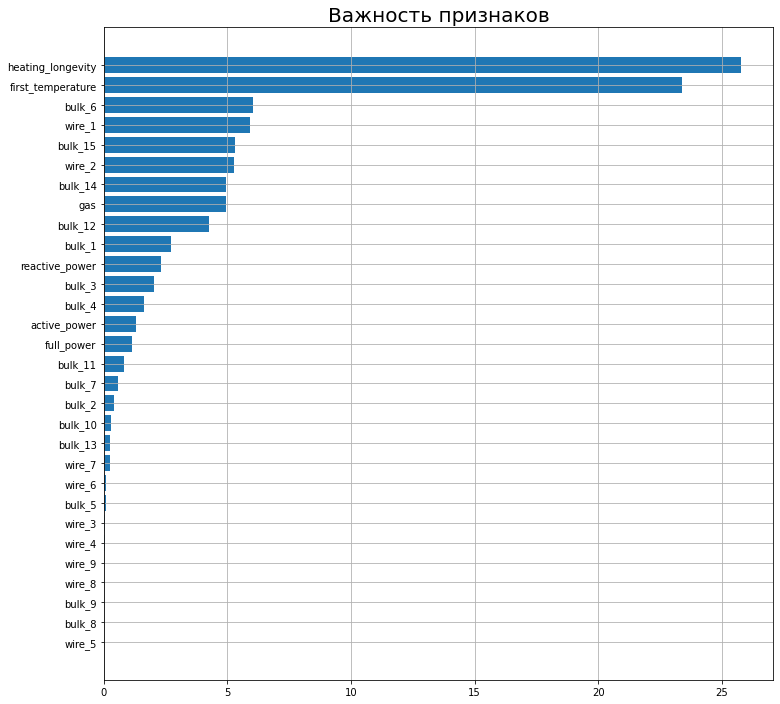

In [204]:
fig = plt.figure(figsize=(12, 12))
plt.barh(range(len(sorted_idx)), cat_features[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X_test.columns)[sorted_idx])
plt.title('Важность признаков', fontsize=20)
plt.grid(True)
plt.show()

Самыми значимыми признаками являются длительность нагрева, первая температура, bulk_6 и wire_1.

Признаки с самыми низкими уровнями значимости - wire_5, bulk_8, bulk_9, wire_8, wire_9.

**Проверим лучшую модель на тестовой выборке**

In [205]:
y_pred = cat_model.predict(X_test)

In [206]:
mae_test = mean_absolute_error(y_test, y_pred).round(2)

In [207]:
mae_test

5.73

Значение метрики на тестовой выборке составляет 5.73.

## Общий вывод

В данной работе производилась разработка модели машинного обучения для прогнозирования температуры сплава при выплавке металла.

Заказчиком были предоставлены следующие данные:
- данные об электродах;
- данные о подаче сыпучих материалов (объём);
- данные о подаче сыпучих материалов (время);
- данные о продувке сплава газом;
- результаты измерения температуры;
- данные о проволочных материалах (объём);
- данные о проволочных материалах (время).

Целевым признаком для модели является последняя температура, замеренная в ковше.

На этапе предобработки данных все промежуточные замеры были исключены и оставлены первый замер и последний. Не были использованы в качестве признаков временные данные о подаче сыпучих и проволочных материалов, т.к. сам факт их подачи характеризуется ненуливым их значением. Пропуски в значениях сыпучих и проволочных материалов были заменены нулевым значением. Был добавлен новый признак в данные - полная мощность, который рассчитывался по формуле (активная_мощность^2 + реактивная_мощность^2)^0.5. Также был добавлен признак длительность нагрева ковша.

Все, оставленные для модели, признаки были сведены в одну общую таблицу.

На этапе исследовательского анализа были выявлены и устраненны выбросы среди значений признаков.
Среди сыпучих и проволочных материалов отмечено наличие часто ипользуемых материалов и крайне редко используемых.

При подготовке данных для моделей все признаки были отнесены к количественным данным.

Были обучены четыре модели и полученые следующие метрики МАЕ по ним:
- Линейная регрессия, МАЕ = 6.45
- DecisionTreeRegression, MAE = 7.47
- LGBMRegressor, MAE = 6.45
- CatBoost, MAE = 6.28.

Лучшая модель CatBoost на тестовой выборке показала метрику равную 5.73. Самыми значимыми признаками являются длительность нагрева, первая температура, bulk_6 и wire_1.
Признаки с самыми низкими уровнями значимости - wire_5, bulk_8, bulk_9, wire_8, wire_9.